In [ ]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (35,20)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
!git clone https://github.com/antekdzi/IFT6269_AAH.git

fatal: destination path 'IFT6269_AAH' already exists and is not an empty directory.


In [ ]:
episodes = []
for i in range(5):
    episodes.append(pd.read_csv('/content/starwars_episode_{}_edges.csv'.format(i+1)))

In [ ]:
all_episodes = pd.concat(episodes)

In [ ]:
all_episodes.head()

Source  Target        Type  weight  episode   Source_ID  value Target_ID
0       2       1  undirected       1        1     QUI-GON     33     R2-D2
1       5       1  undirected      26        1       TC-14      5     R2-D2
2       9       1  undirected       1        1     TEY HOW      5     R2-D2
3      10       1  undirected       9        1     EMPEROR     14     R2-D2
4      12       1  undirected      22        1  SIO BIBBLE      8     R2-D2

In [ ]:
edges = all_episodes.groupby(['Source_ID','Target_ID']).agg({'weight':'sum'}).reset_index()

In [ ]:
edges.sort_values('weight',ascending=False).head()

Source_ID Target_ID  weight
163      LUKE   RIEEKAN      33
224     R2-D2    ANAKIN      30
153      LEIA      LUKE      27
284    TARKIN     C-3PO      26
300     TC-14     R2-D2      26

In [ ]:
SW = nx.from_pandas_edgelist(edges, 
                            source='Source_ID',
                            target='Target_ID',
                            edge_attr='weight' )

In [ ]:
print(nx.info(SW))


Graph with 84 nodes and 342 edges


In [ ]:
weighted_degrees = dict(nx.degree(SW,weight='weight'))
max_degree = max(weighted_degrees.values())

In [ ]:
weighted_degrees

{'ANAKIN': 112,
 'BAIL ORGANA': 35,
 'BERU': 14,
 'BIGGS': 51,
 'BOBA FETT': 36,
 'BOSS NASS': 70,
 'BRAVO TWO': 5,
 'C-3PO': 140,
 'CAMIE': 14,
 'CAPTAIN ANTILLES': 1,
 'CAPTAIN PANAKA': 11,
 'CAPTAIN TYPHO': 16,
 'CHEWBACCA': 46,
 'CLIEGG': 1,
 'CLONE COMMANDER CODY': 2,
 'CLONE COMMANDER GREE': 5,
 'COUNT DOOKU': 41,
 'DACK': 2,
 'DARTH MAUL': 11,
 'DARTH VADER': 6,
 'DERLIN': 2,
 'DODONNA': 5,
 'DOFINE': 14,
 'EMPEROR': 44,
 'FANG ZAR': 7,
 'FODE/BEED': 7,
 'GENERAL CEEL': 8,
 'GENERAL GRIEVOUS': 32,
 'GIDDEAN DANU': 14,
 'GOLD LEADER': 9,
 'GREEDO': 6,
 'HAN': 9,
 'JABBA': 6,
 'JANGO FETT': 1,
 'JANSON': 2,
 'JAR JAR': 53,
 'JIRA': 27,
 'JOBAL': 6,
 'KI-ADI-MUNDI': 23,
 'KITSTER': 7,
 'LAMA SU': 6,
 'LEIA': 70,
 'LUKE': 85,
 'MACE WINDU': 36,
 'MON MOTHMA': 4,
 'MOTTI': 10,
 'NEEDA': 1,
 'NUTE GUNRAY': 2,
 'OBI-WAN': 66,
 'ODD BALL': 4,
 'ORN FREE TAA': 24,
 'OWEN': 26,
 'OZZEL': 22,
 'PADME': 49,
 'PIETT': 4,
 'PK-4': 6,
 'PLO KOON': 3,
 'POGGLE': 8,
 'QUI-GON': 24,
 'R2-D2': 252

In [ ]:
import seaborn as sns

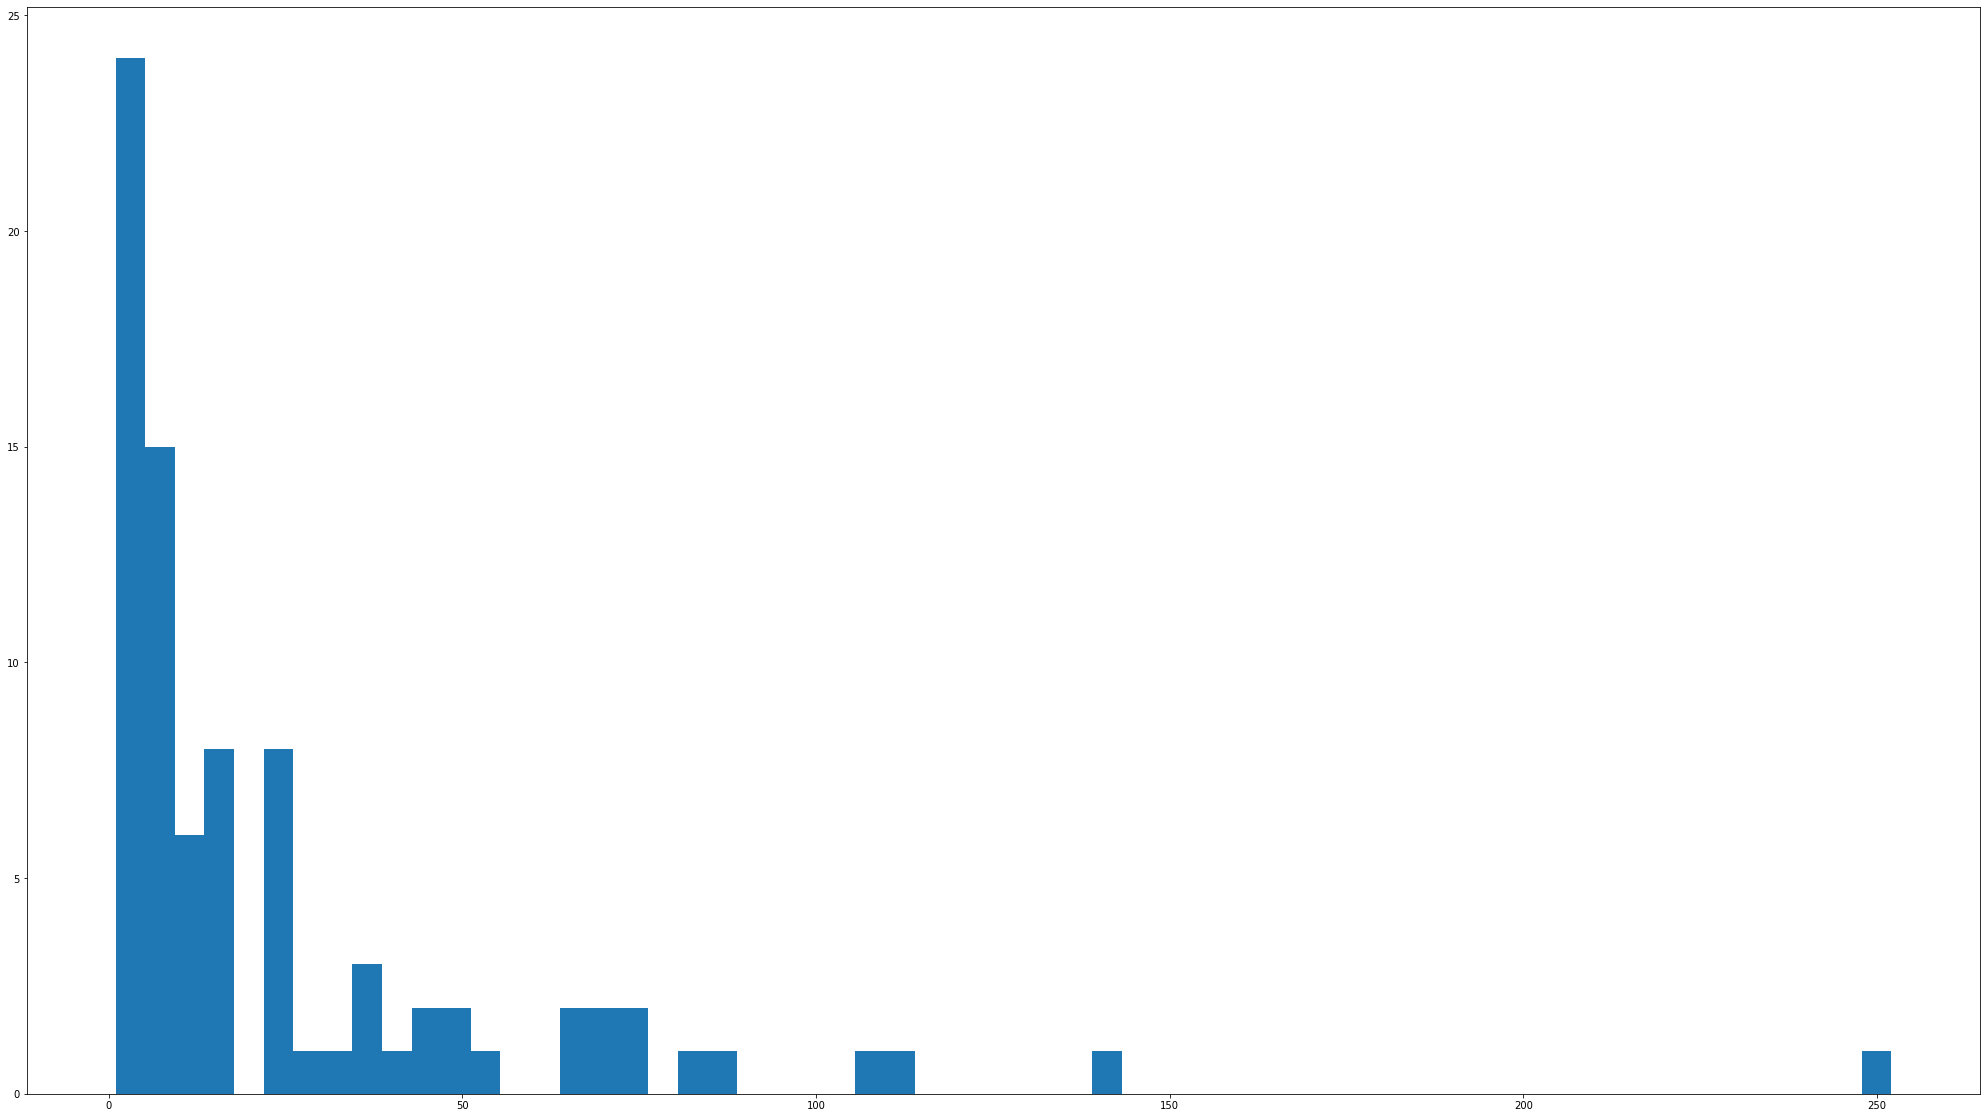

In [ ]:
h = plt.hist(weighted_degrees.values(), bins = 60)


In [ ]:
subG = SW.subgraph([n for n in weighted_degrees if weighted_degrees[n]>2])

In [ ]:
subG

In [ ]:
print(nx.info(subG))

Graph with 72 nodes and 323 edges


In [ ]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

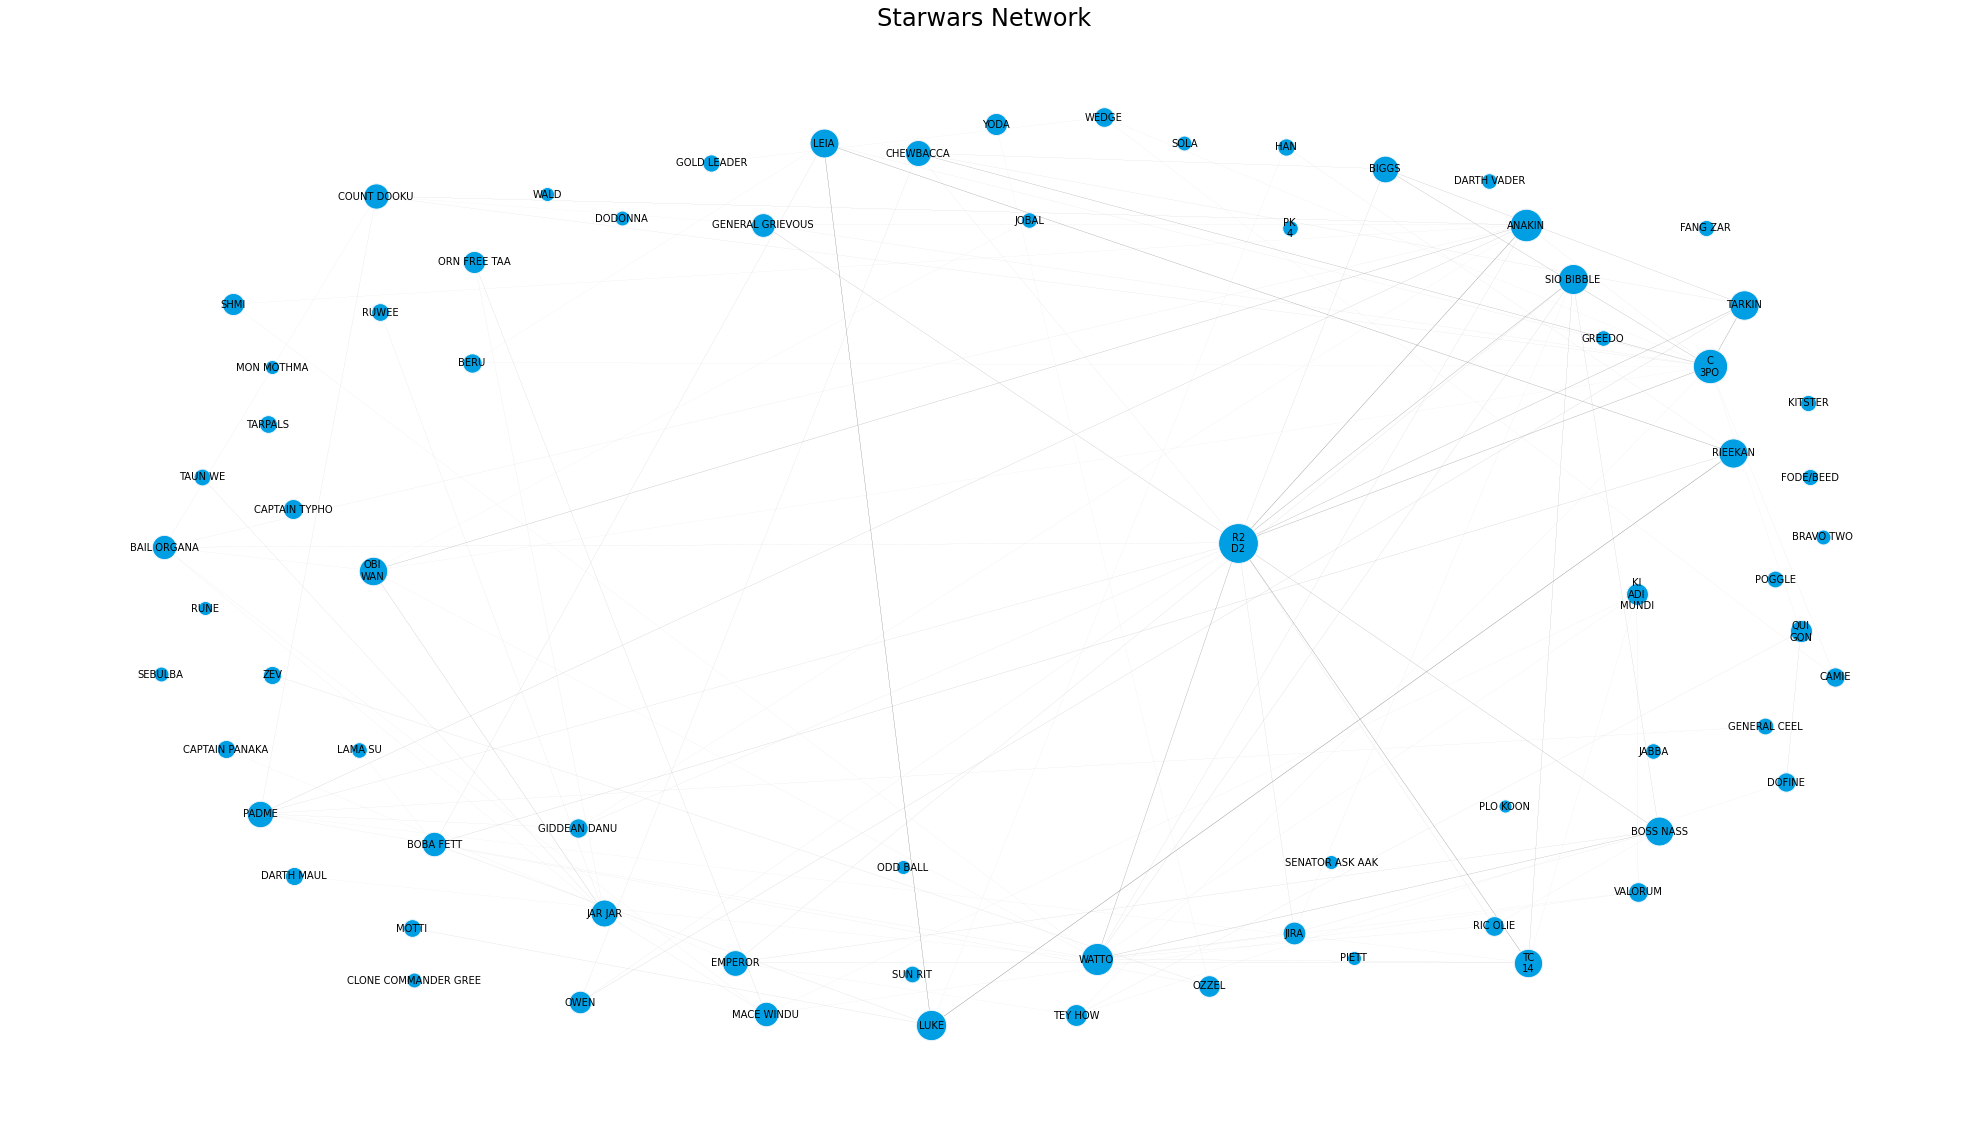

In [ ]:
plt.axis('off')
plt.title('Starwars Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>1},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>2:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [ ]:
infection_times = {}

In [ ]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [ ]:
infection_times

{}

In [ ]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Star Wars Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


In [ ]:
infection_times = {'LUKE':-1,'CHEWBACCA':-1,'R2-D2':0}

{'LUKE': -1, 'CHEWBACCA': -1, 'R2-D2': 0, 'ANAKIN': 1, 'GREEDO': 1, 'OWEN': 1, 'RIC OLIE': 1, 'TARKIN': 1, 'TC-14': 1, 'WATTO': 1, 'OBI-WAN': 2, 'PADME': 2, 'C-3PO': 2, 'BOSS NASS': 2, 'GENERAL CEEL': 2, 'ORN FREE TAA': 3, 'SIO BIBBLE': 3, 'BIGGS': 3, 'LEIA': 3, 'EMPEROR': 3, 'SHMI': 4, 'JAR JAR': 4, 'RIEEKAN': 4, 'TAUN WE': 5, 'KI-ADI-MUNDI': 1}
{'LUKE': -1, 'CHEWBACCA': -1, 'R2-D2': 0, 'ANAKIN': 1, 'GREEDO': 1, 'OWEN': 1, 'RIC OLIE': 1, 'TARKIN': 1, 'TC-14': 1, 'WATTO': 1, 'OBI-WAN': 2, 'PADME': 2, 'C-3PO': 2, 'BOSS NASS': 2, 'GENERAL CEEL': 2, 'ORN FREE TAA': 3, 'SIO BIBBLE': 3, 'BIGGS': 3, 'LEIA': 3, 'EMPEROR': 3, 'SHMI': 4, 'JAR JAR': 4, 'RIEEKAN': 4, 'TAUN WE': 5, 'KI-ADI-MUNDI': 1, 'COUNT DOOKU': 2, 'JIRA': 2}
{'LUKE': -1, 'CHEWBACCA': -1, 'R2-D2': 0, 'ANAKIN': 1, 'GREEDO': 1, 'OWEN': 1, 'RIC OLIE': 1, 'TARKIN': 1, 'TC-14': 1, 'WATTO': 1, 'OBI-WAN': 2, 'PADME': 2, 'C-3PO': 2, 'BOSS NASS': 2, 'GENERAL CEEL': 2, 'ORN FREE TAA': 3, 'SIO BIBBLE': 3, 'BIGGS': 3, 'LEIA': 3, 'EMPEROR':

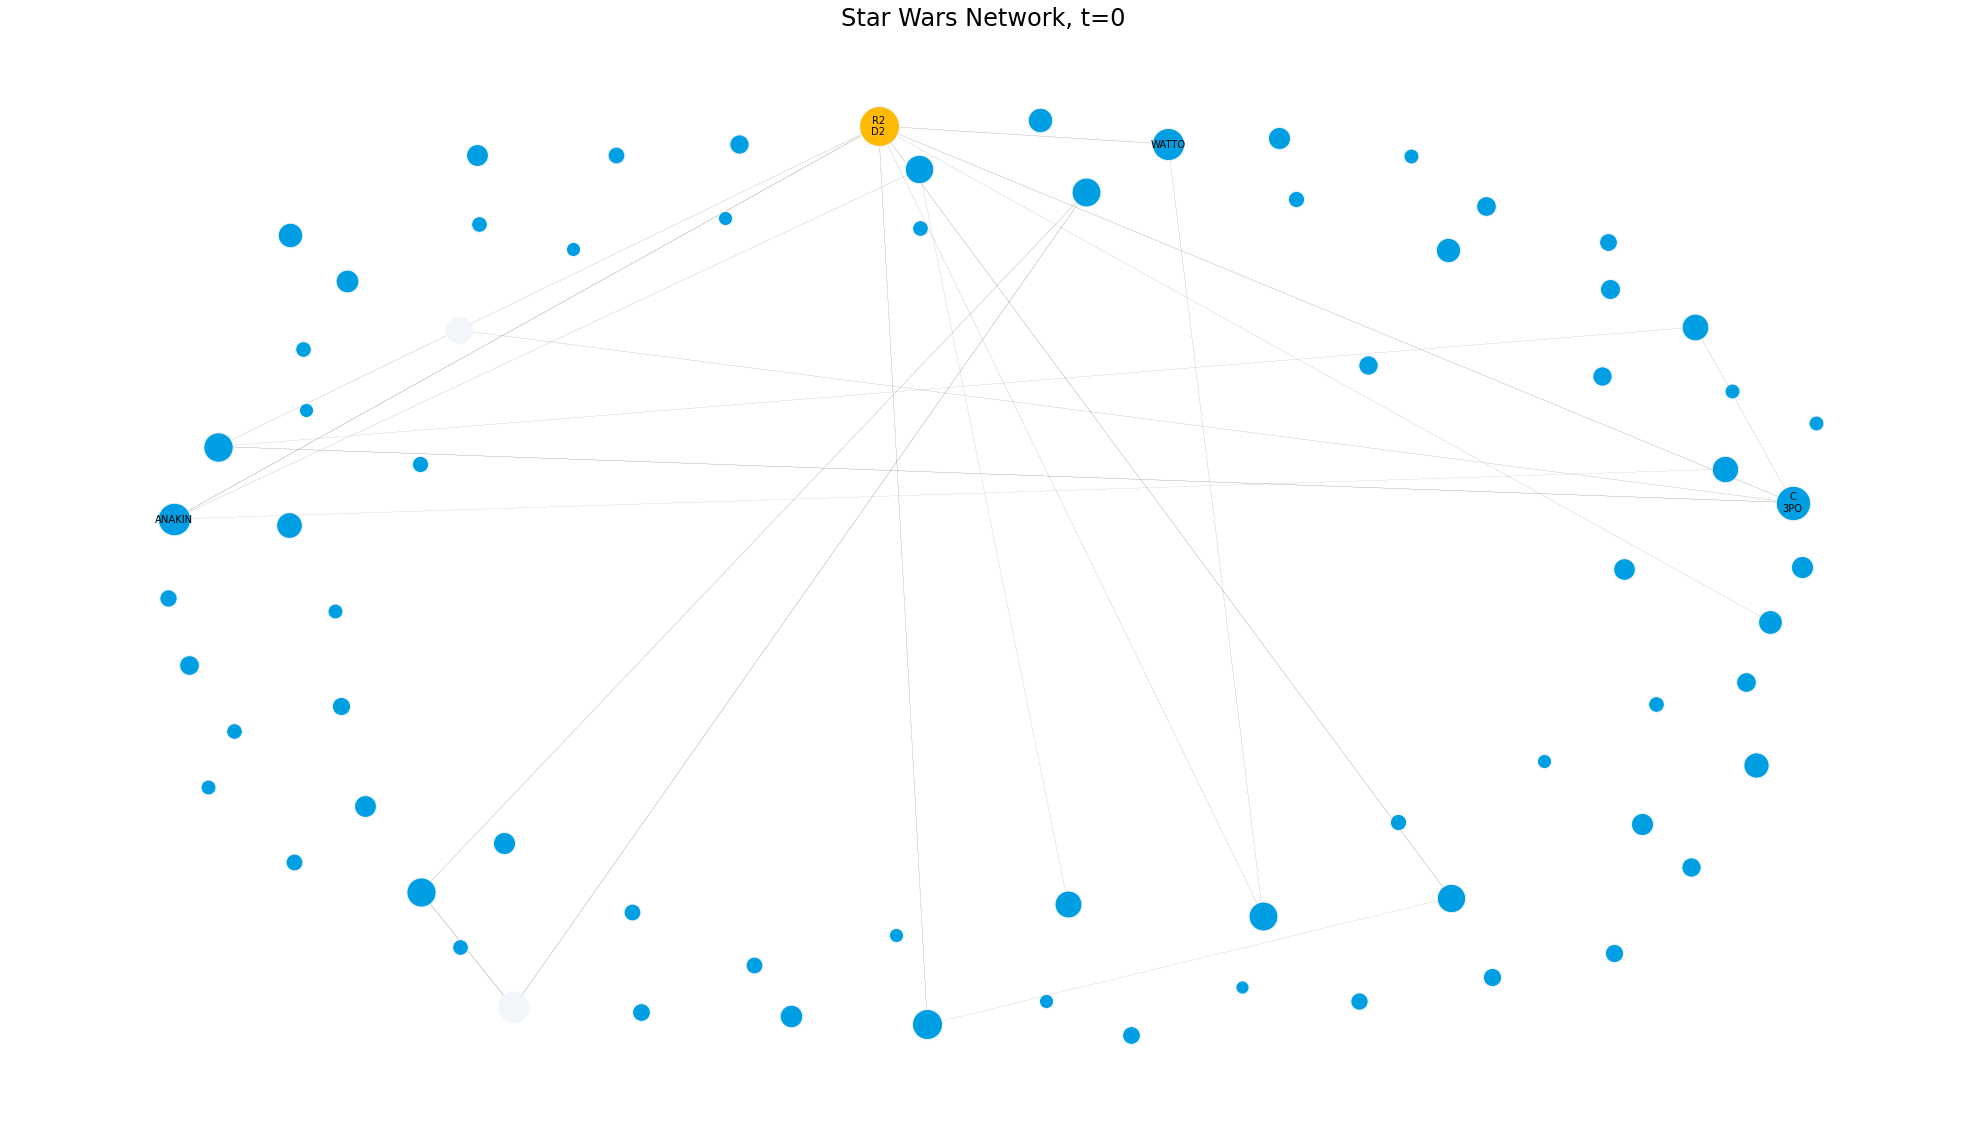

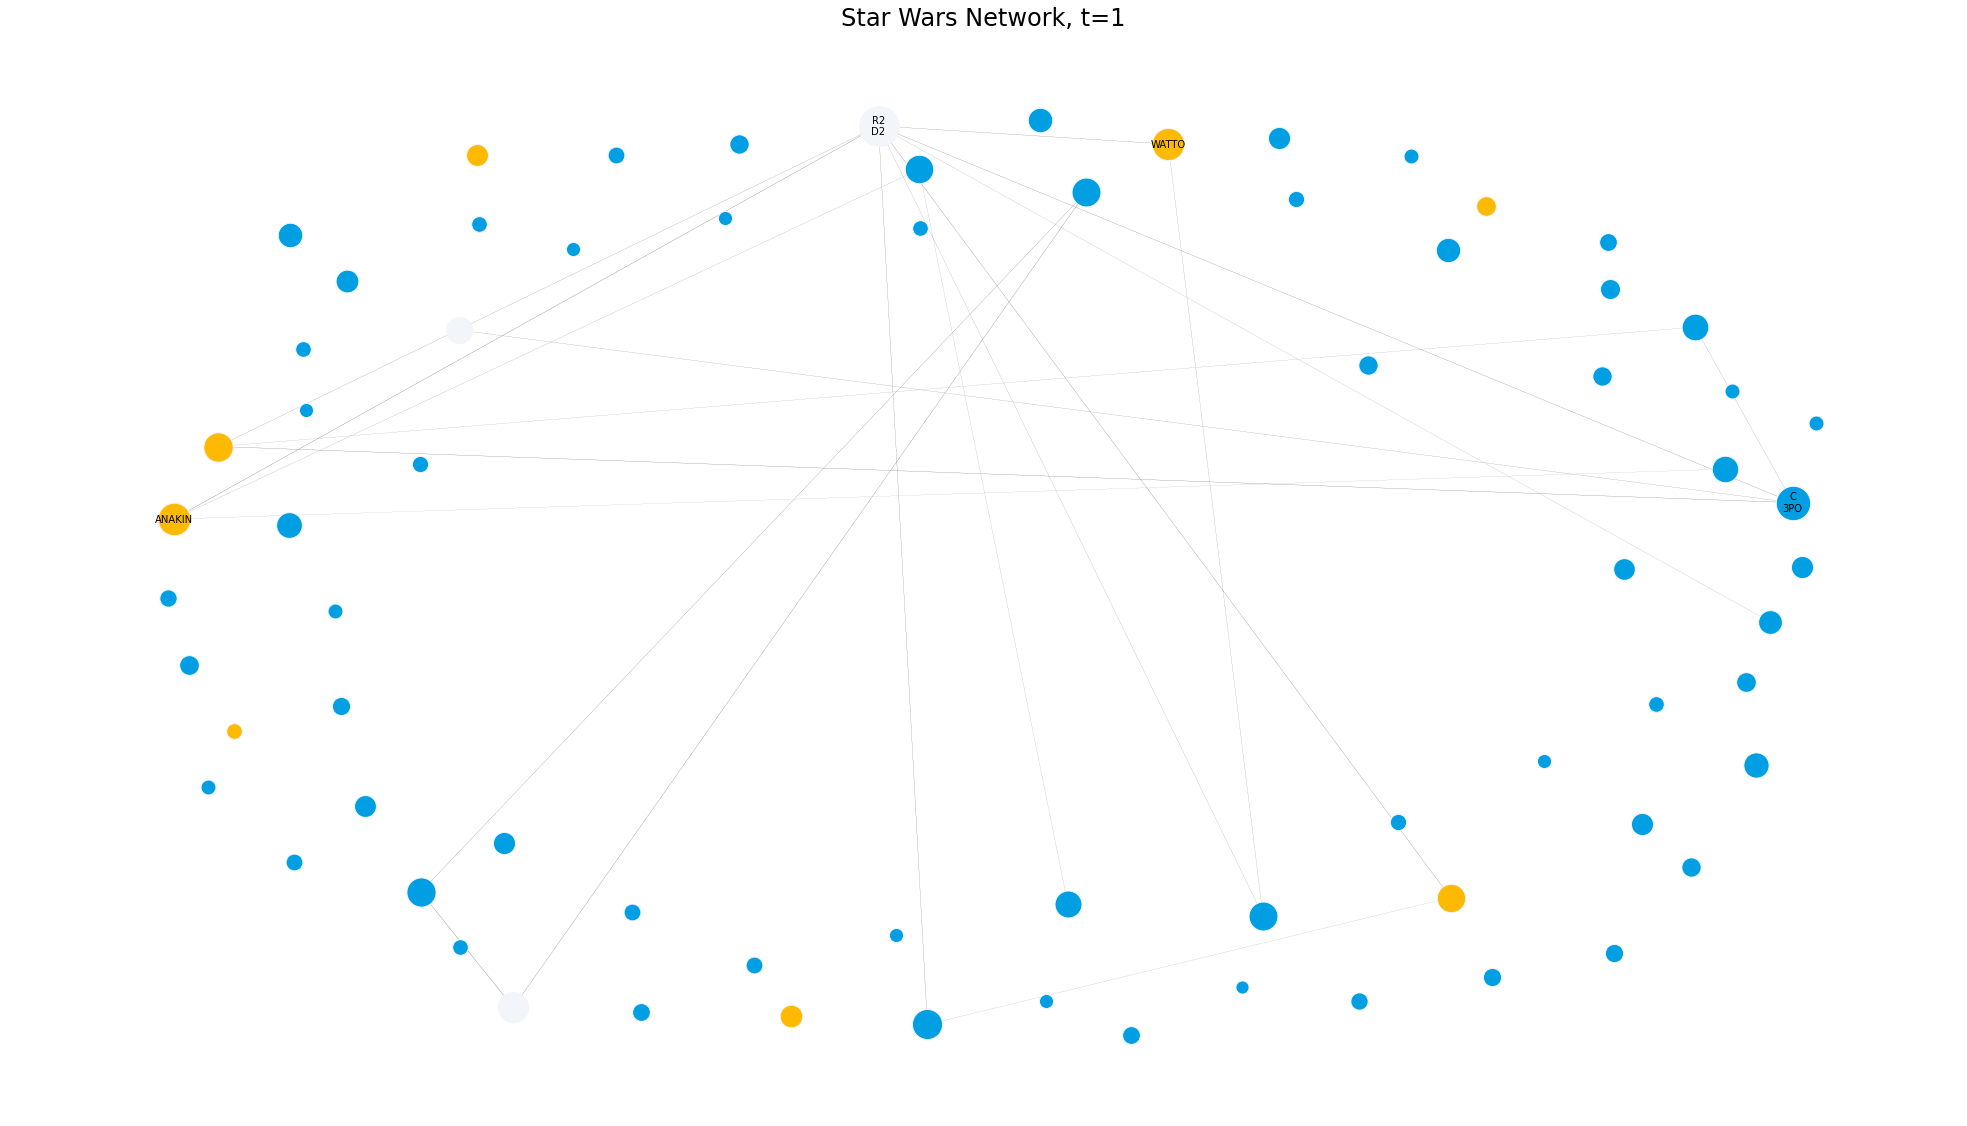

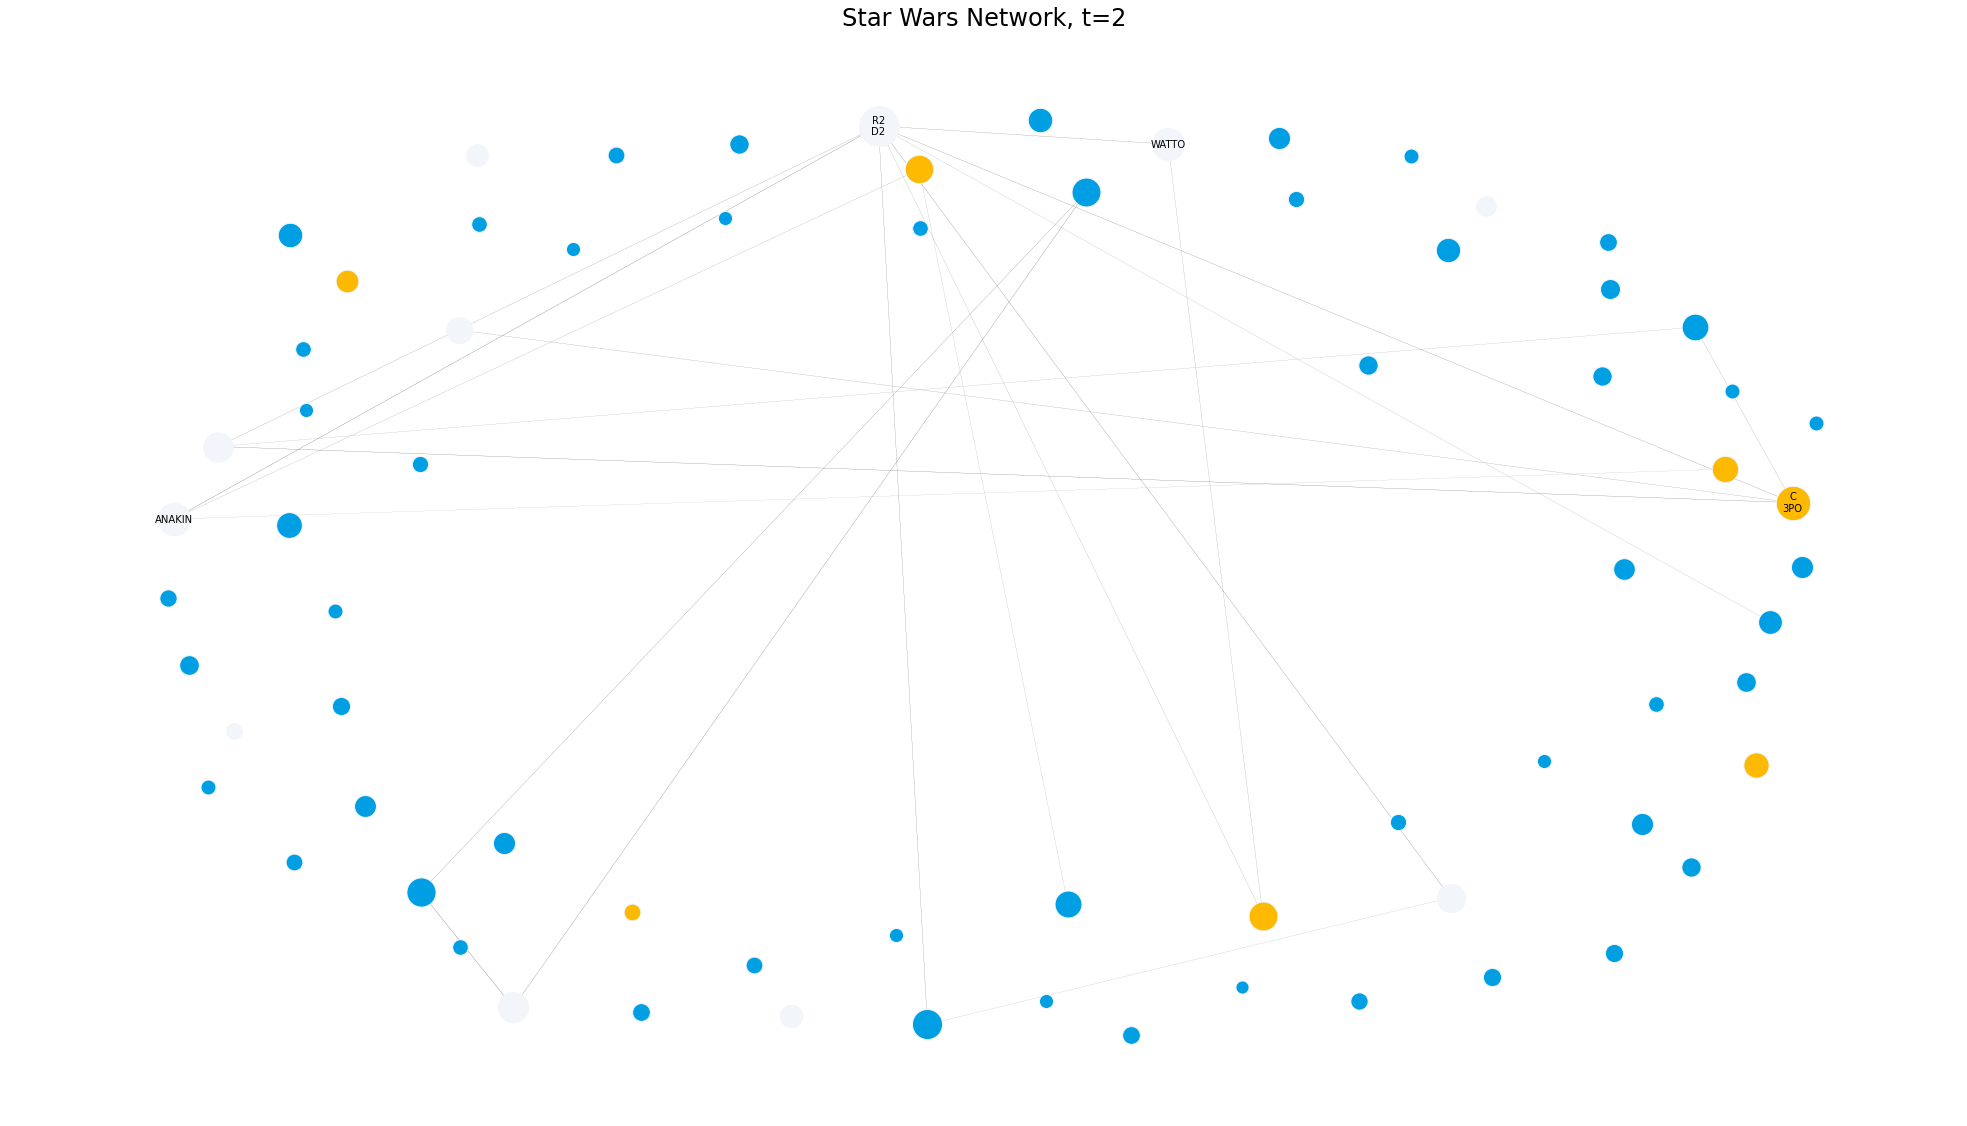

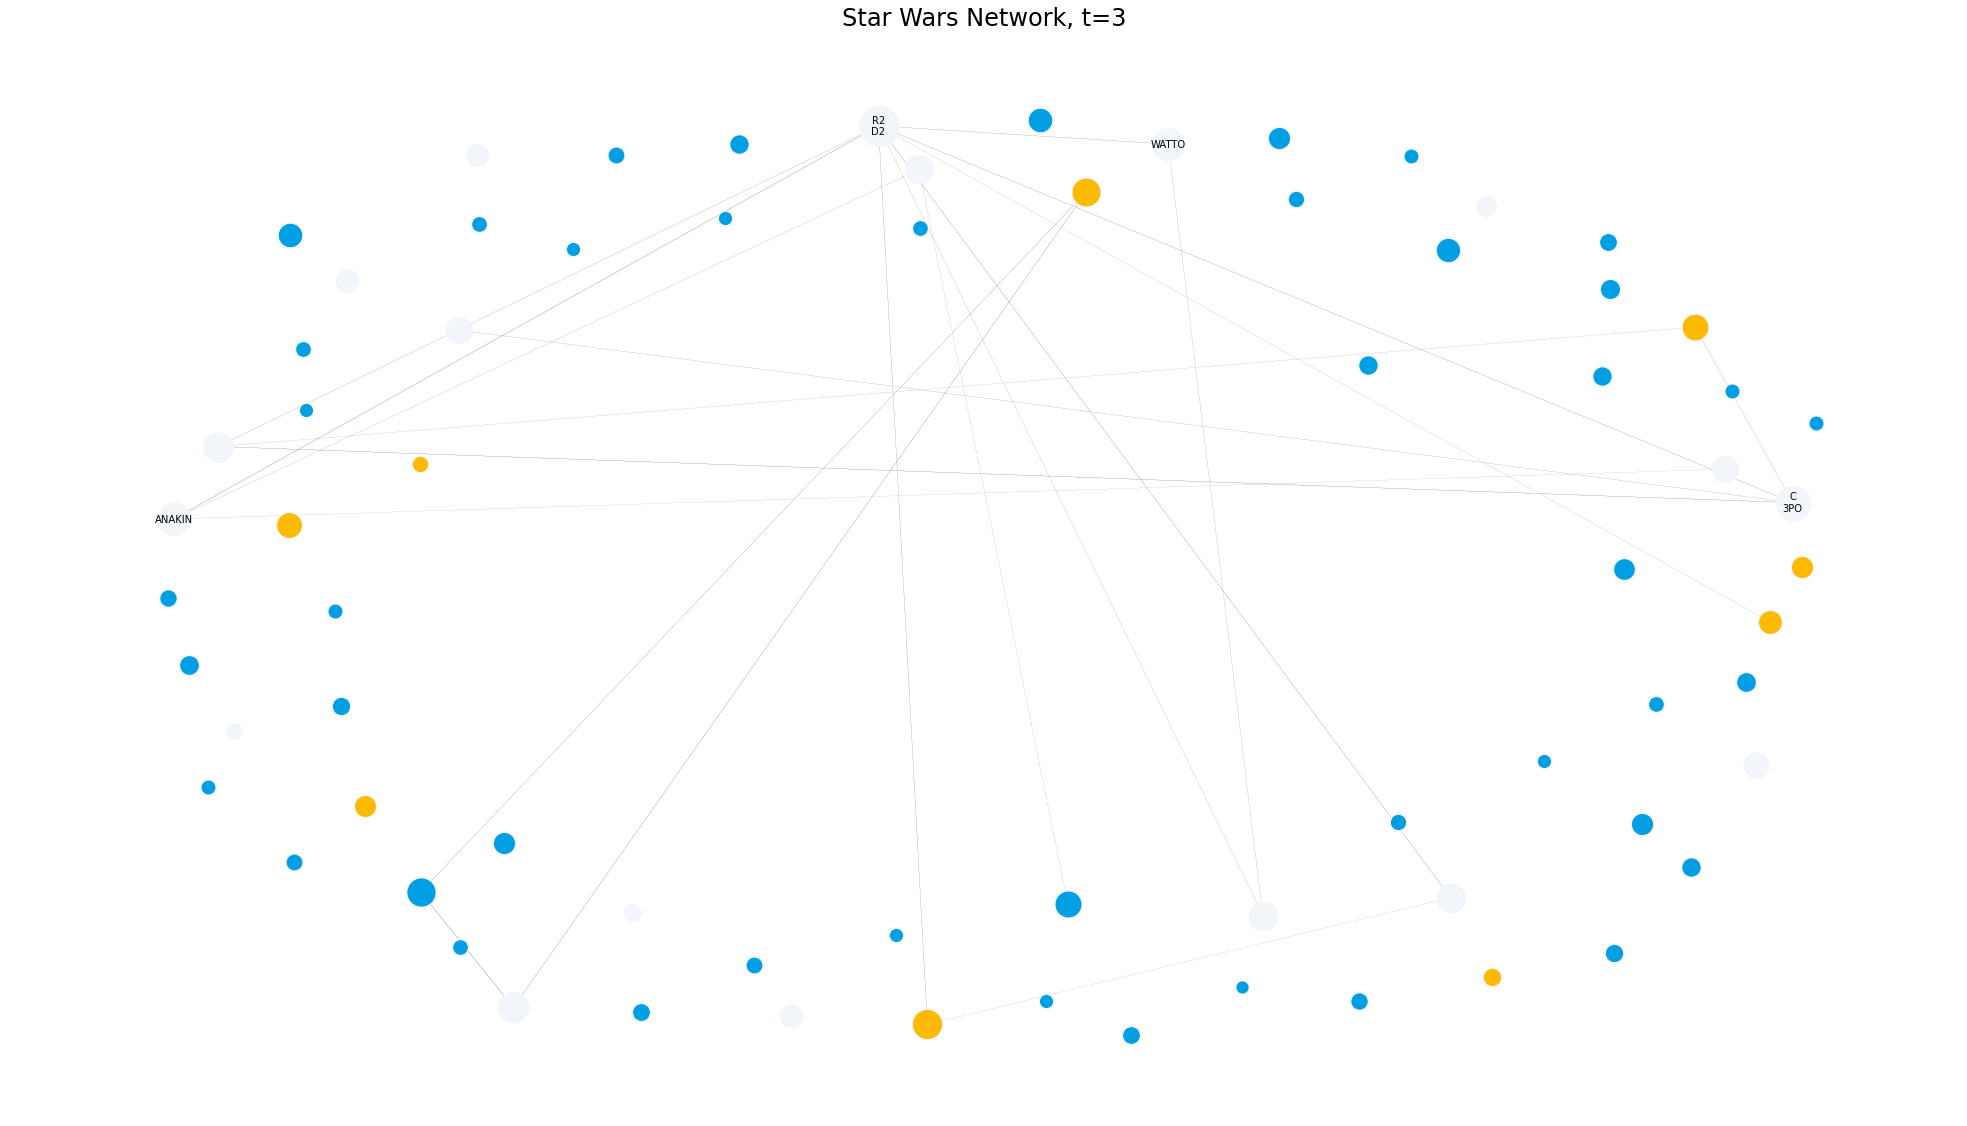

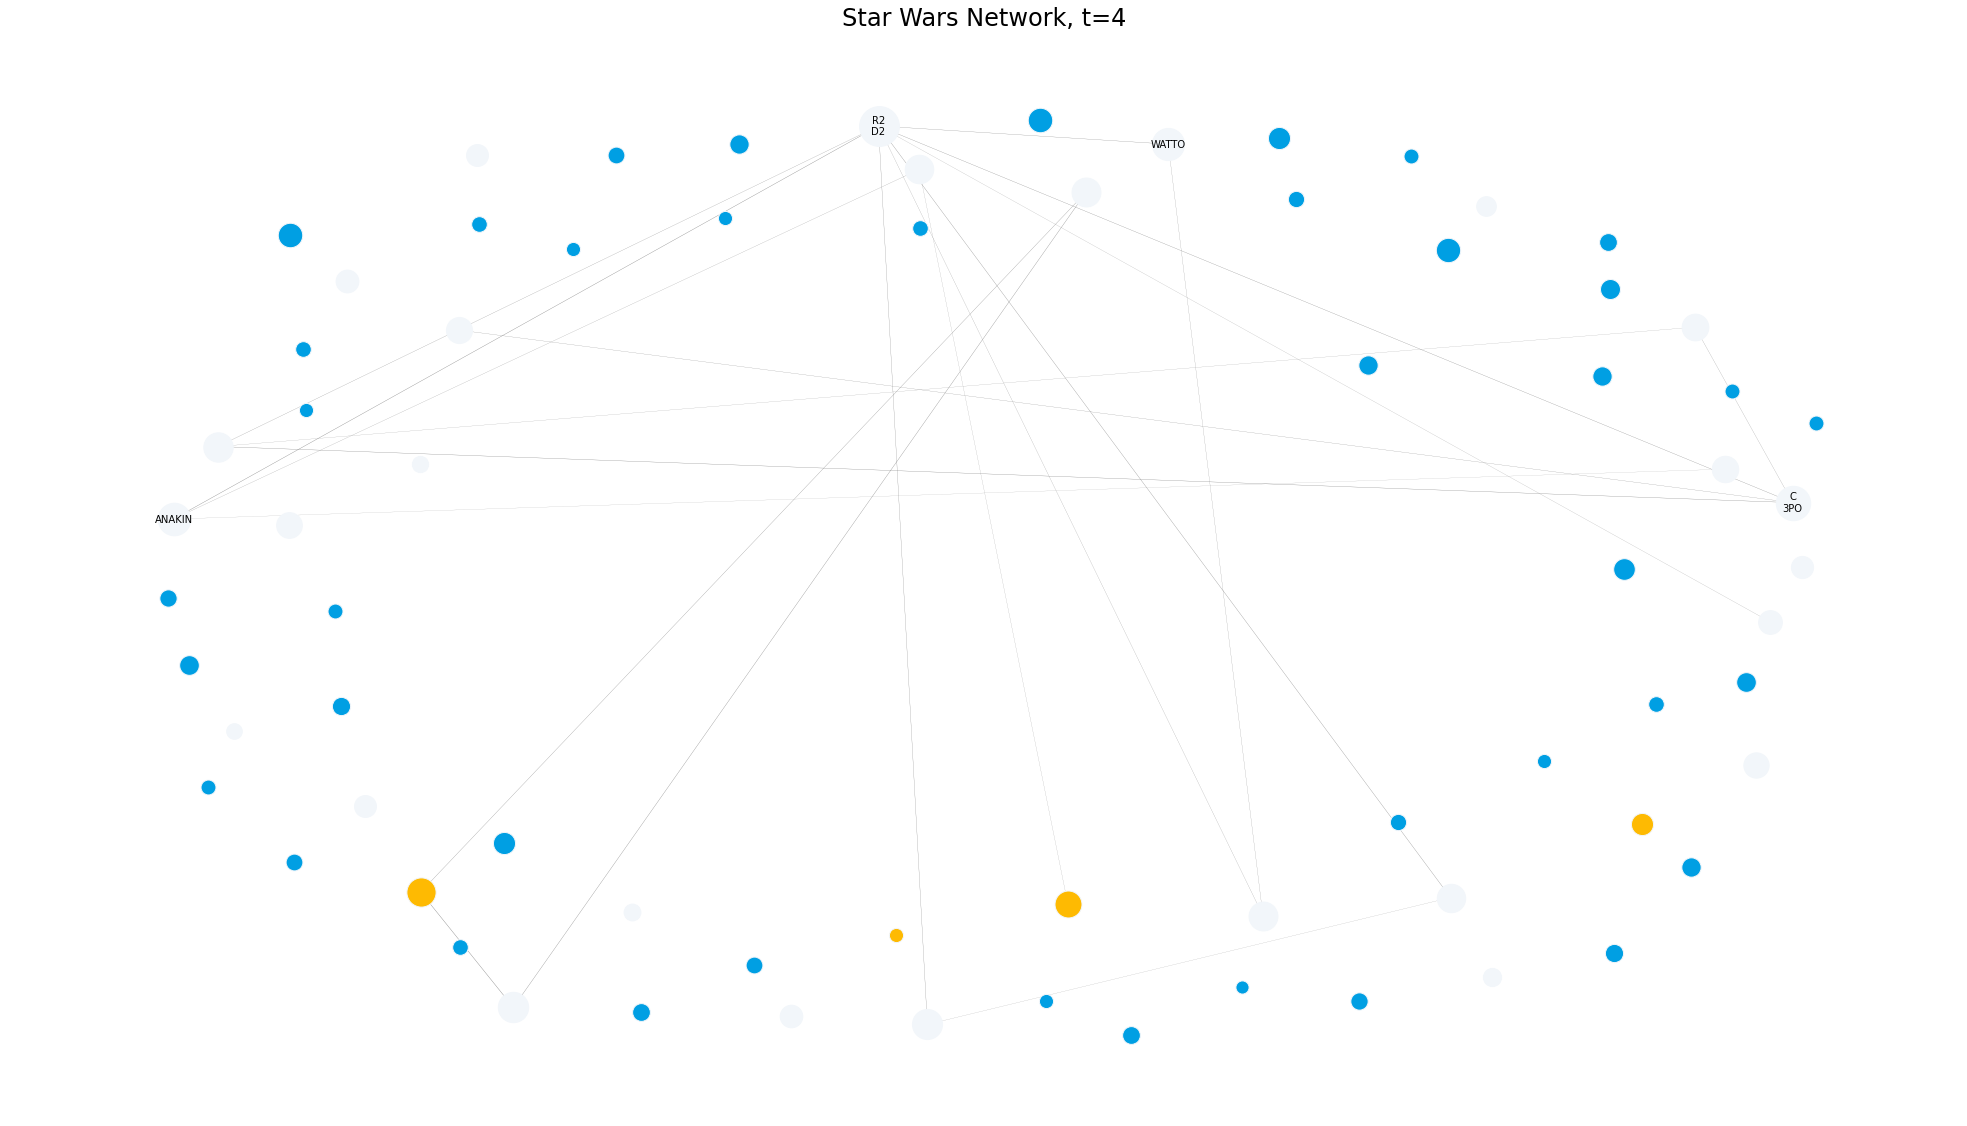

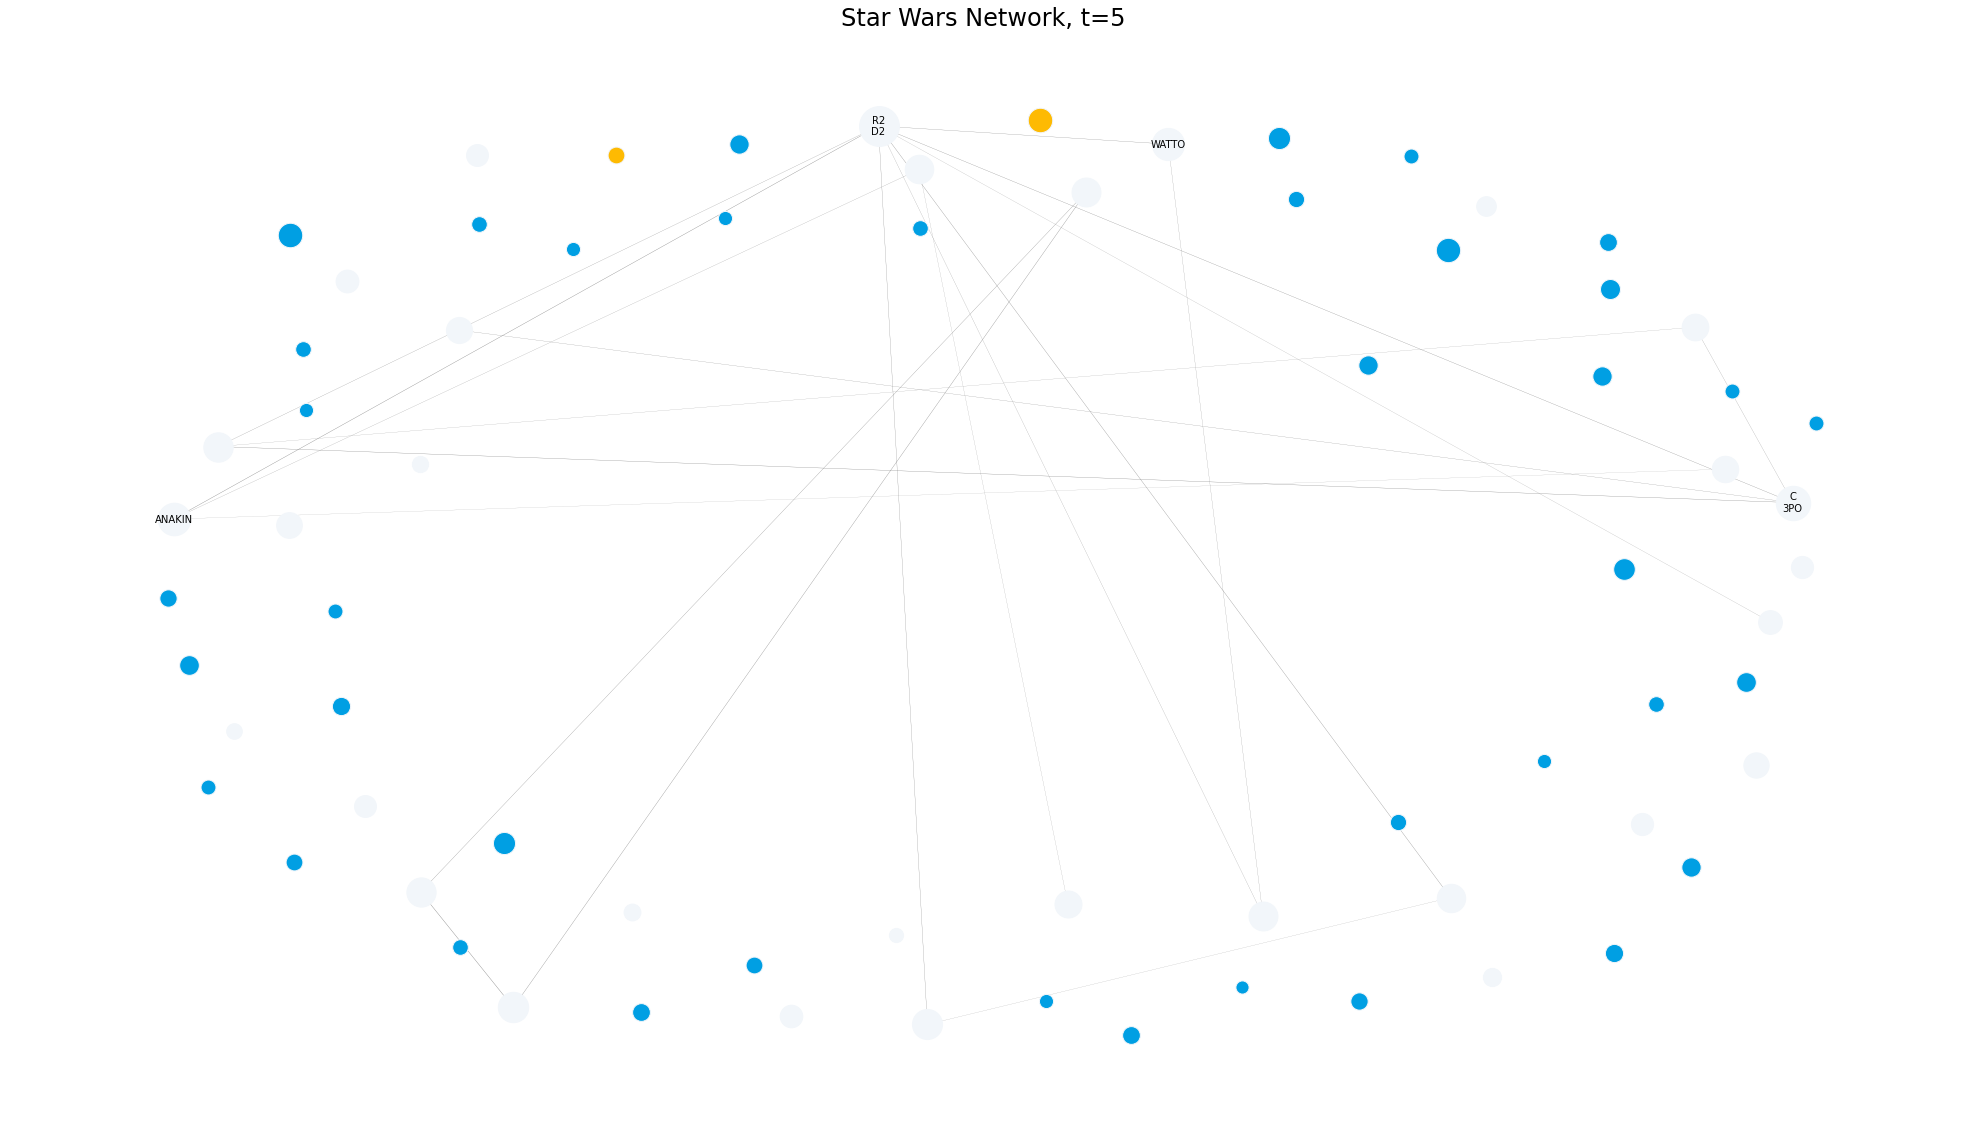

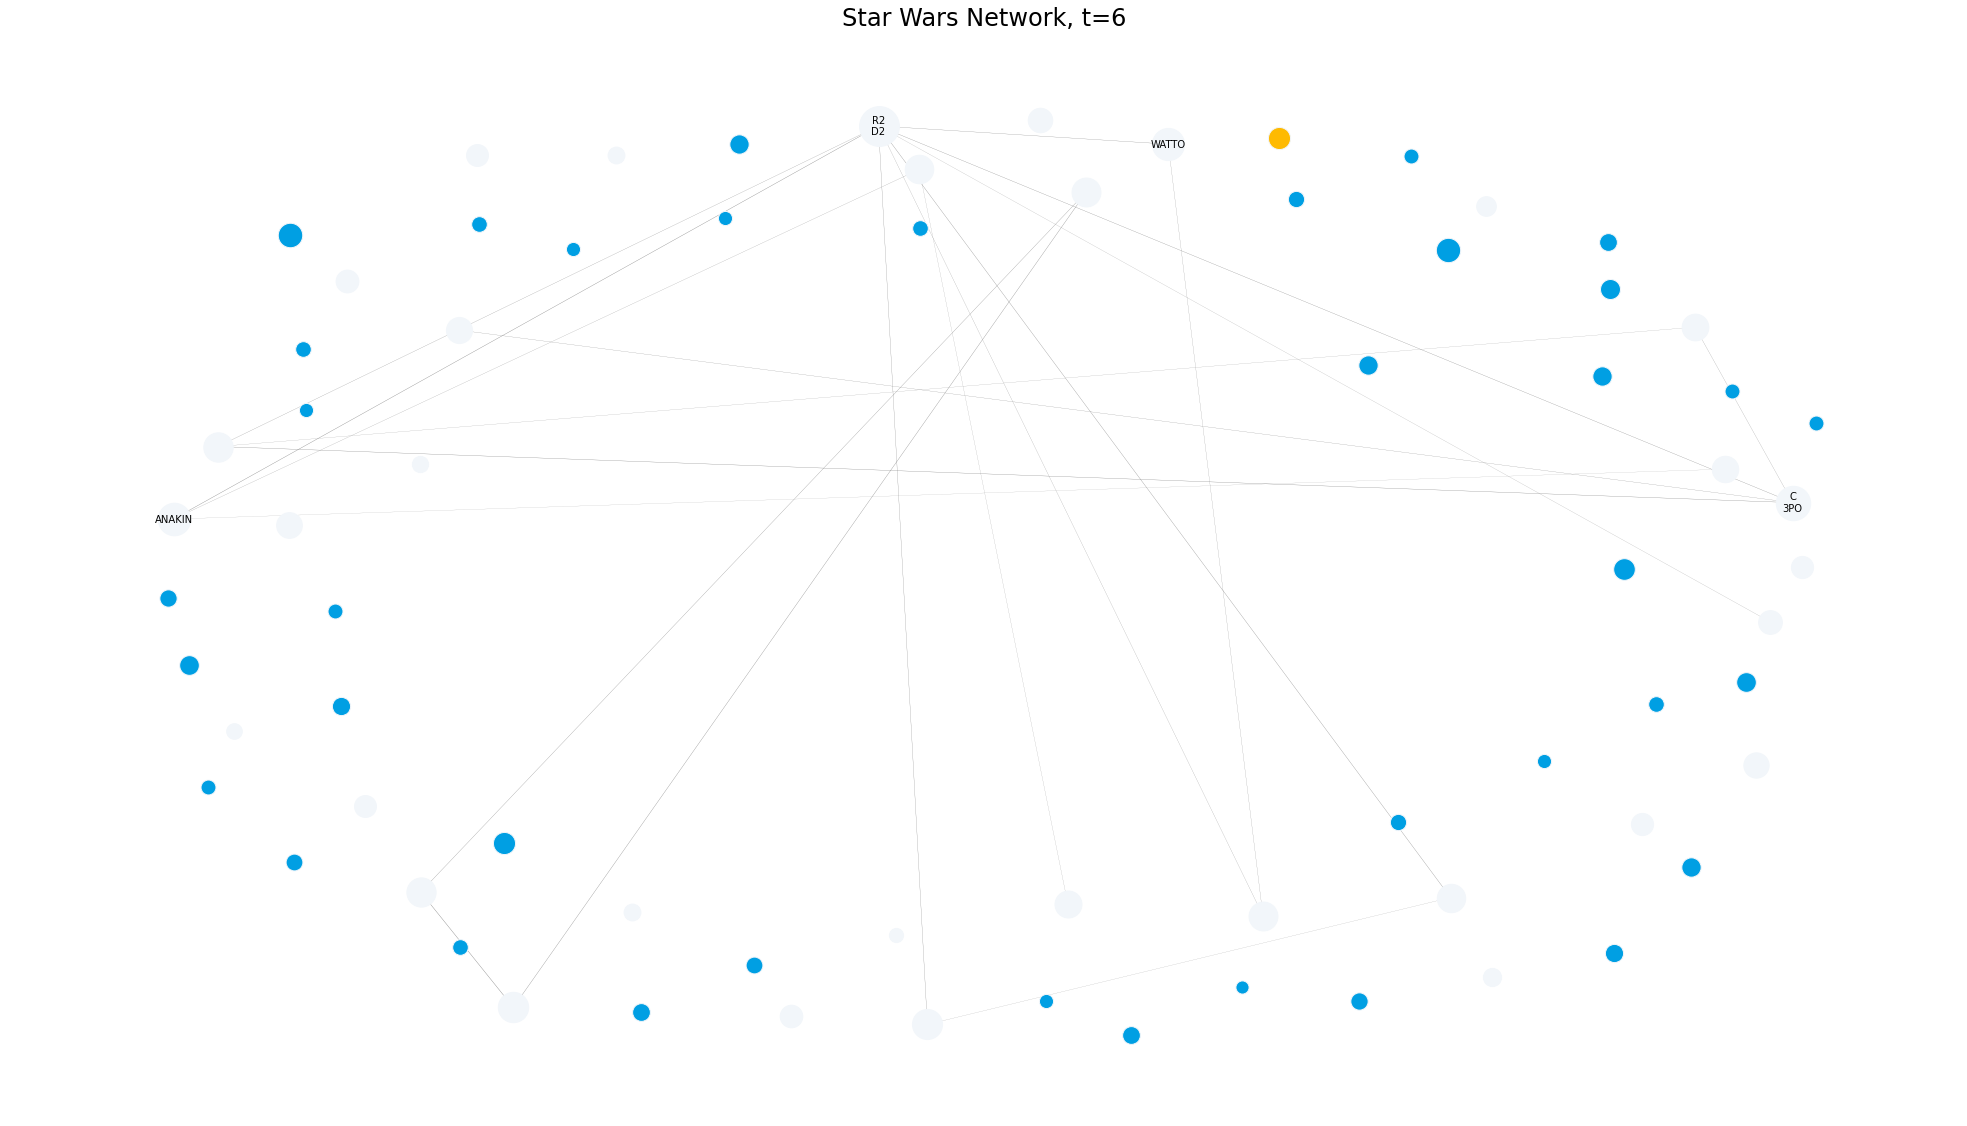

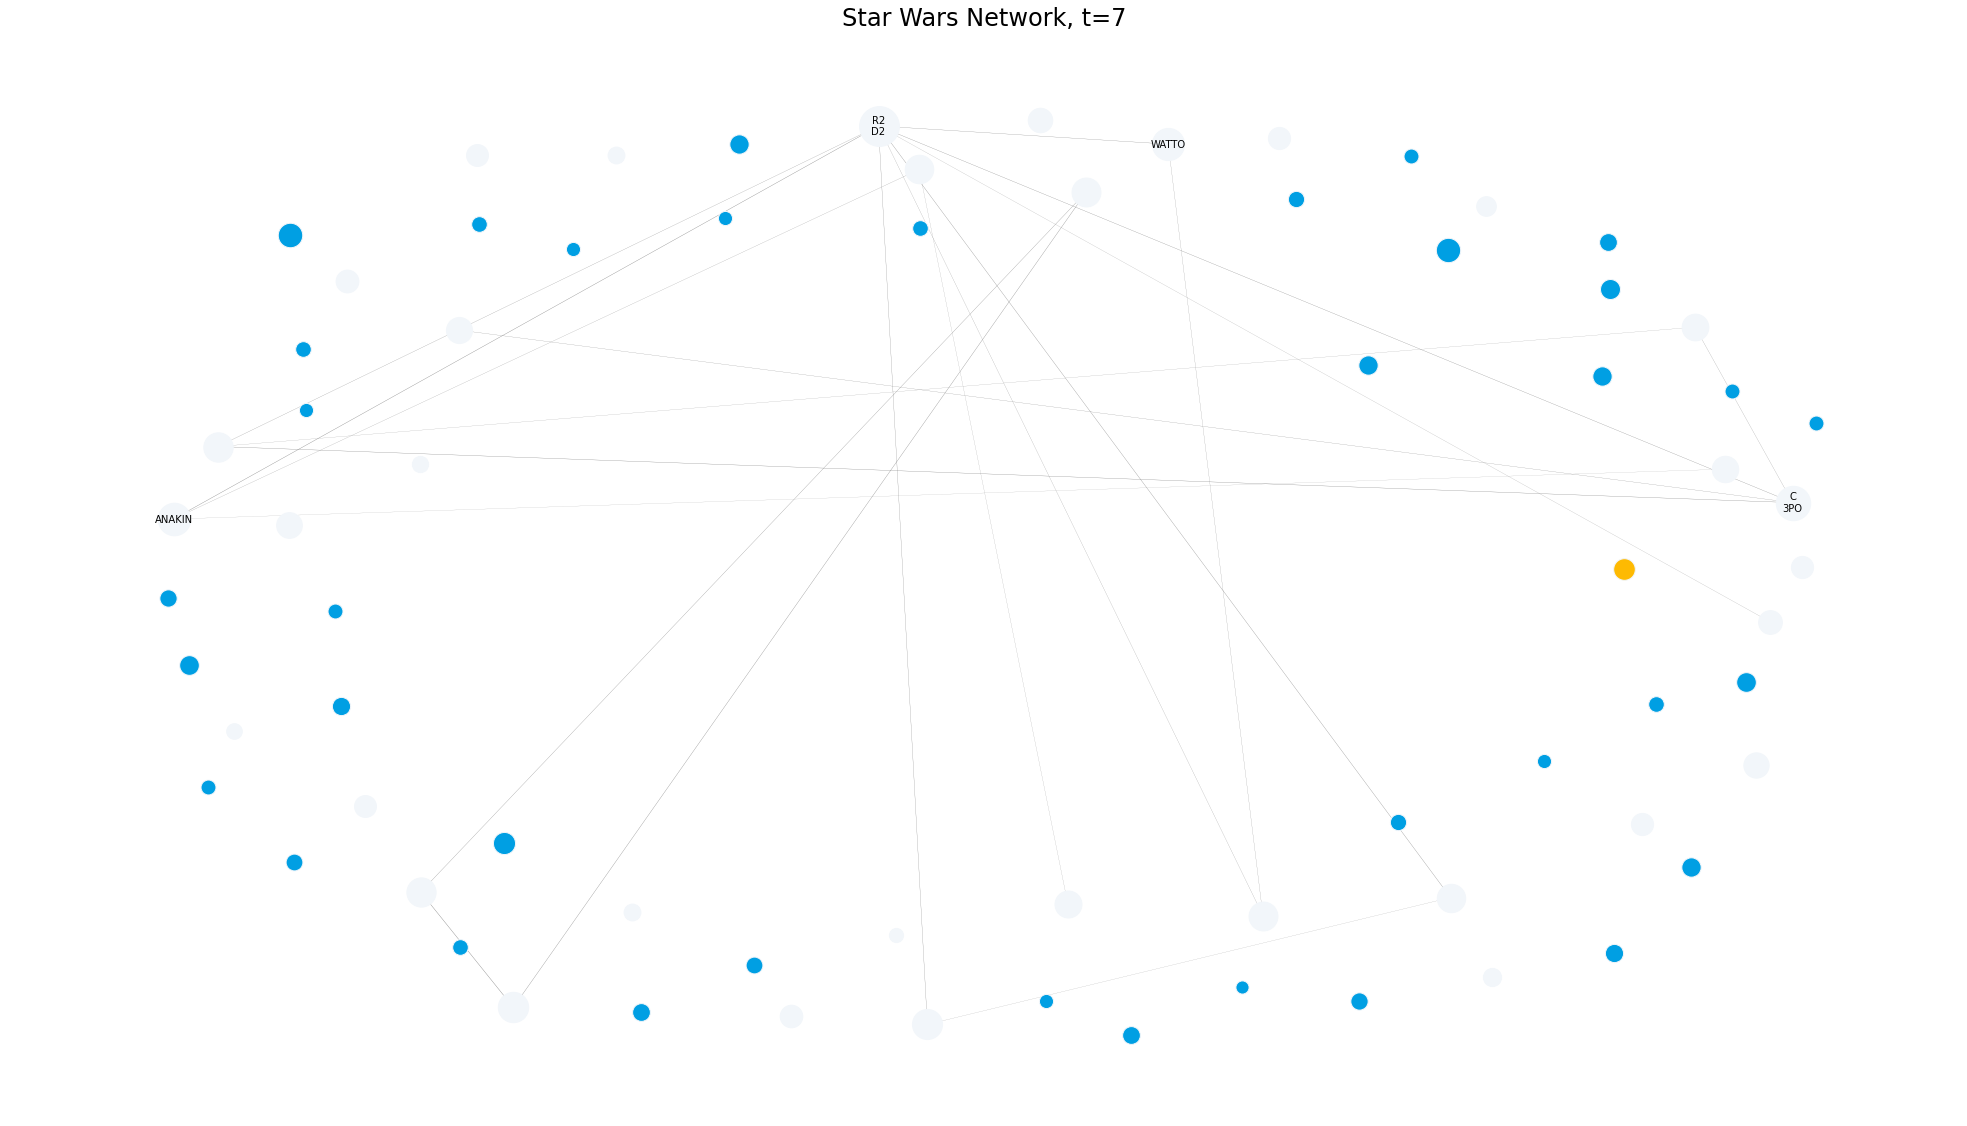

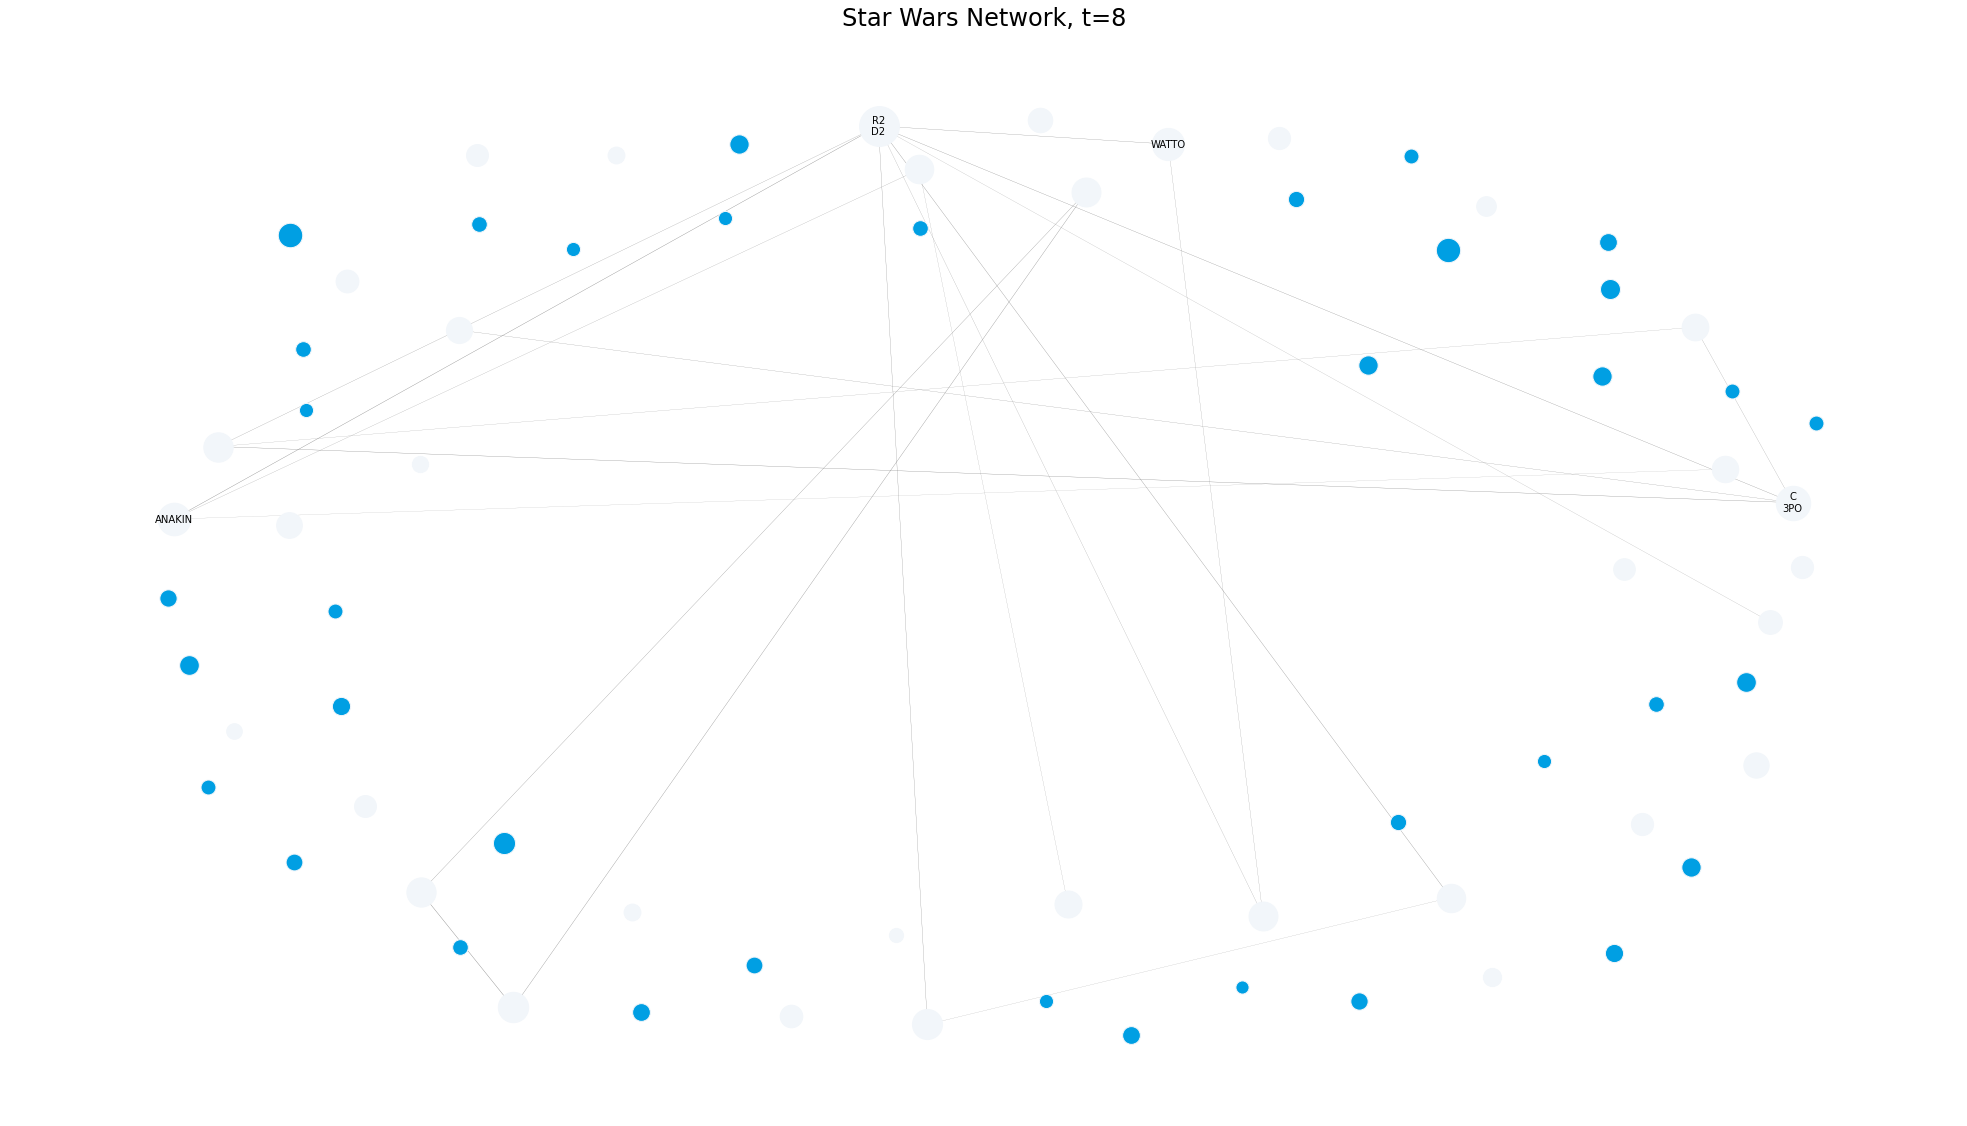

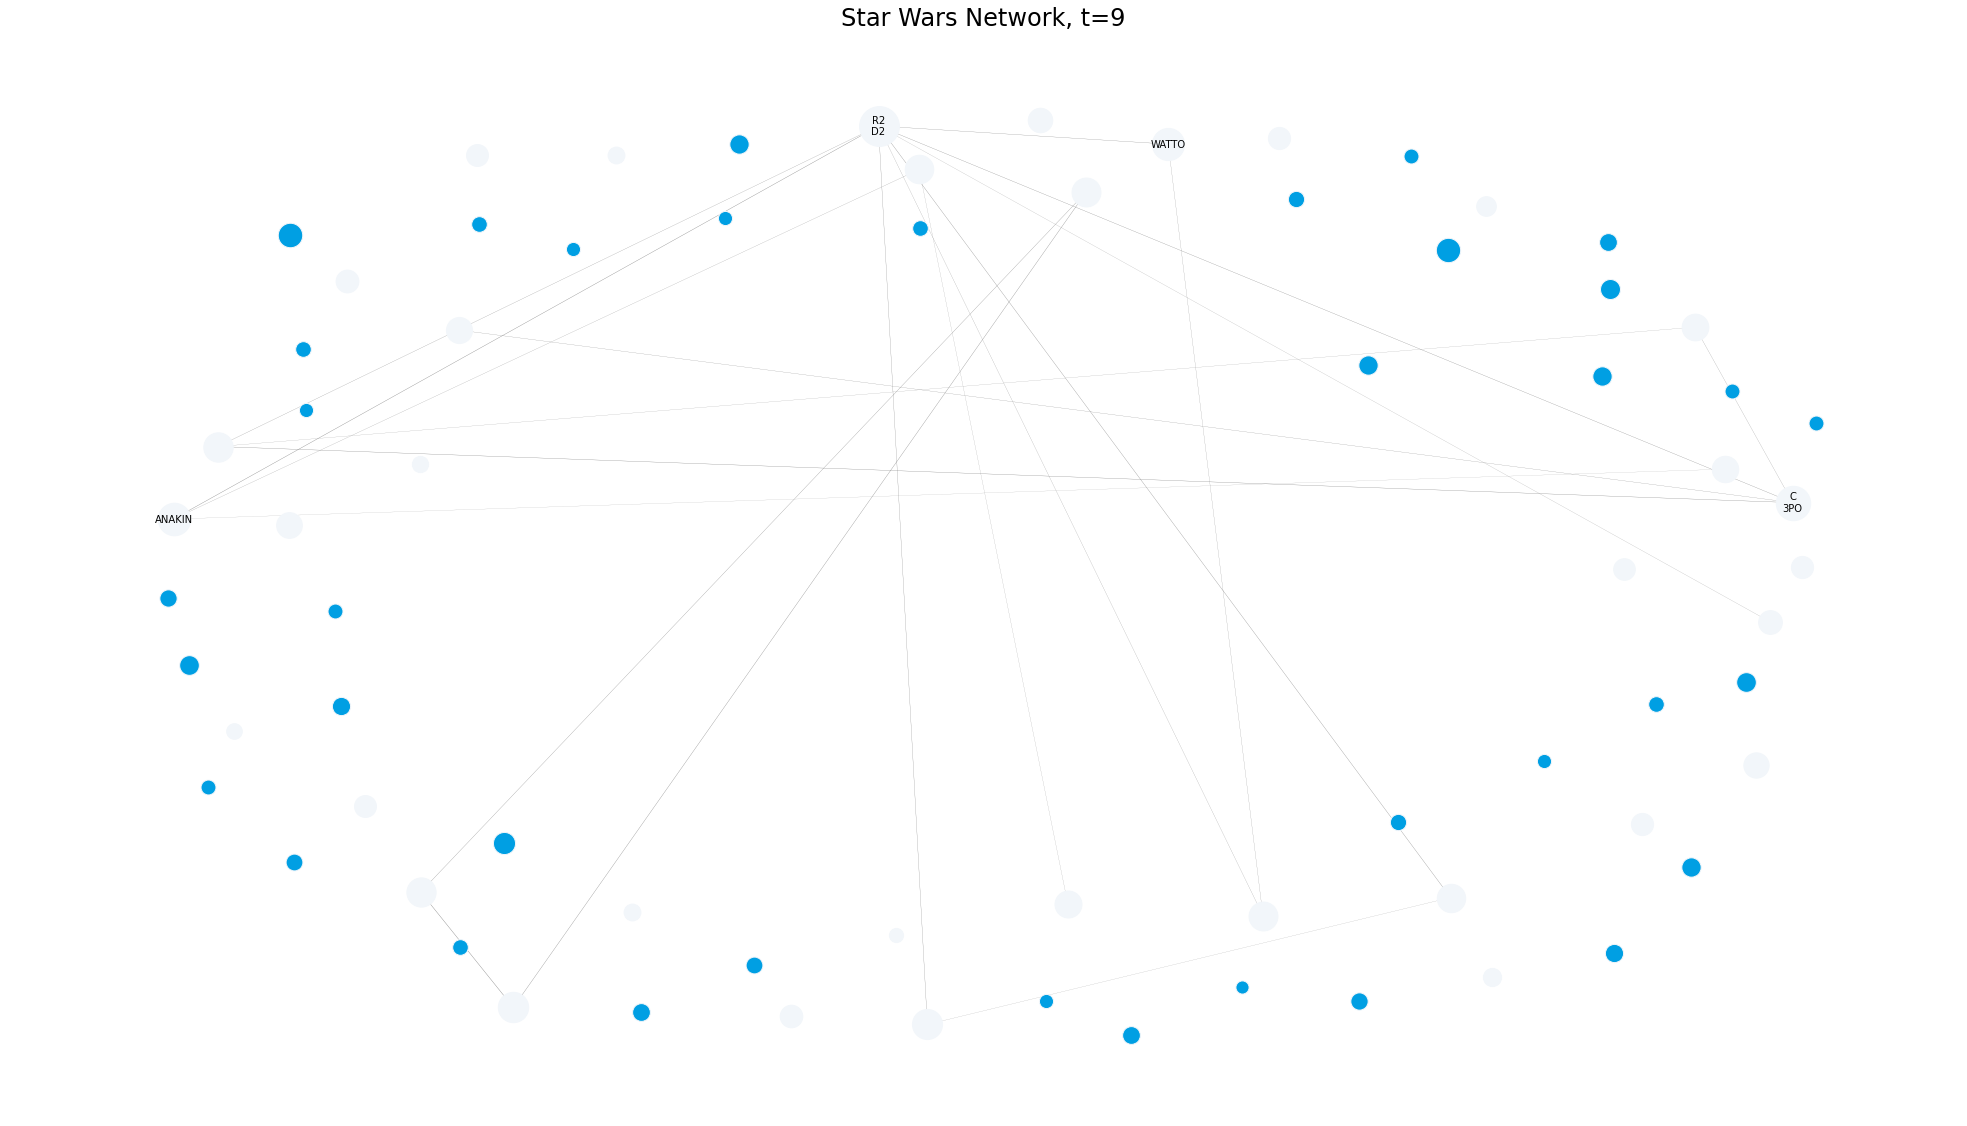

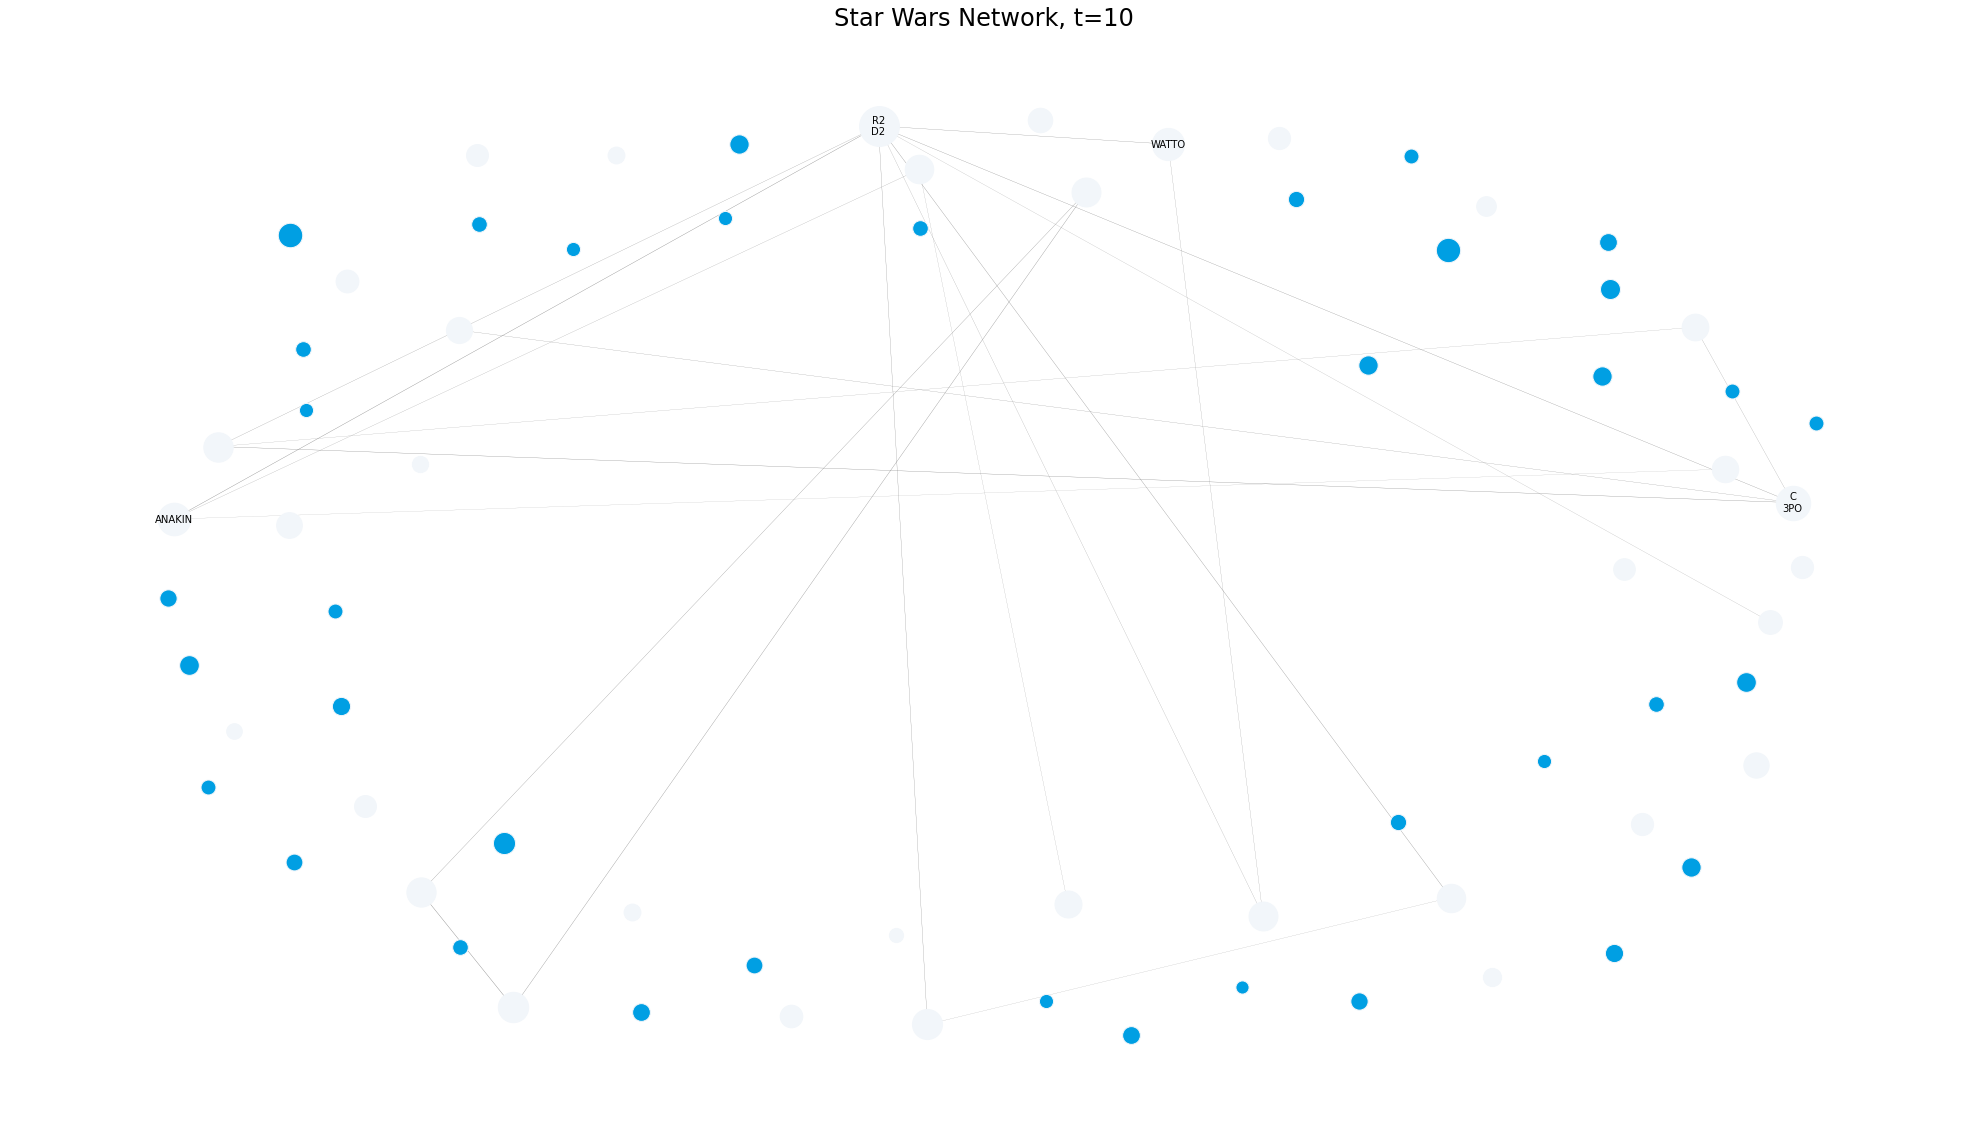

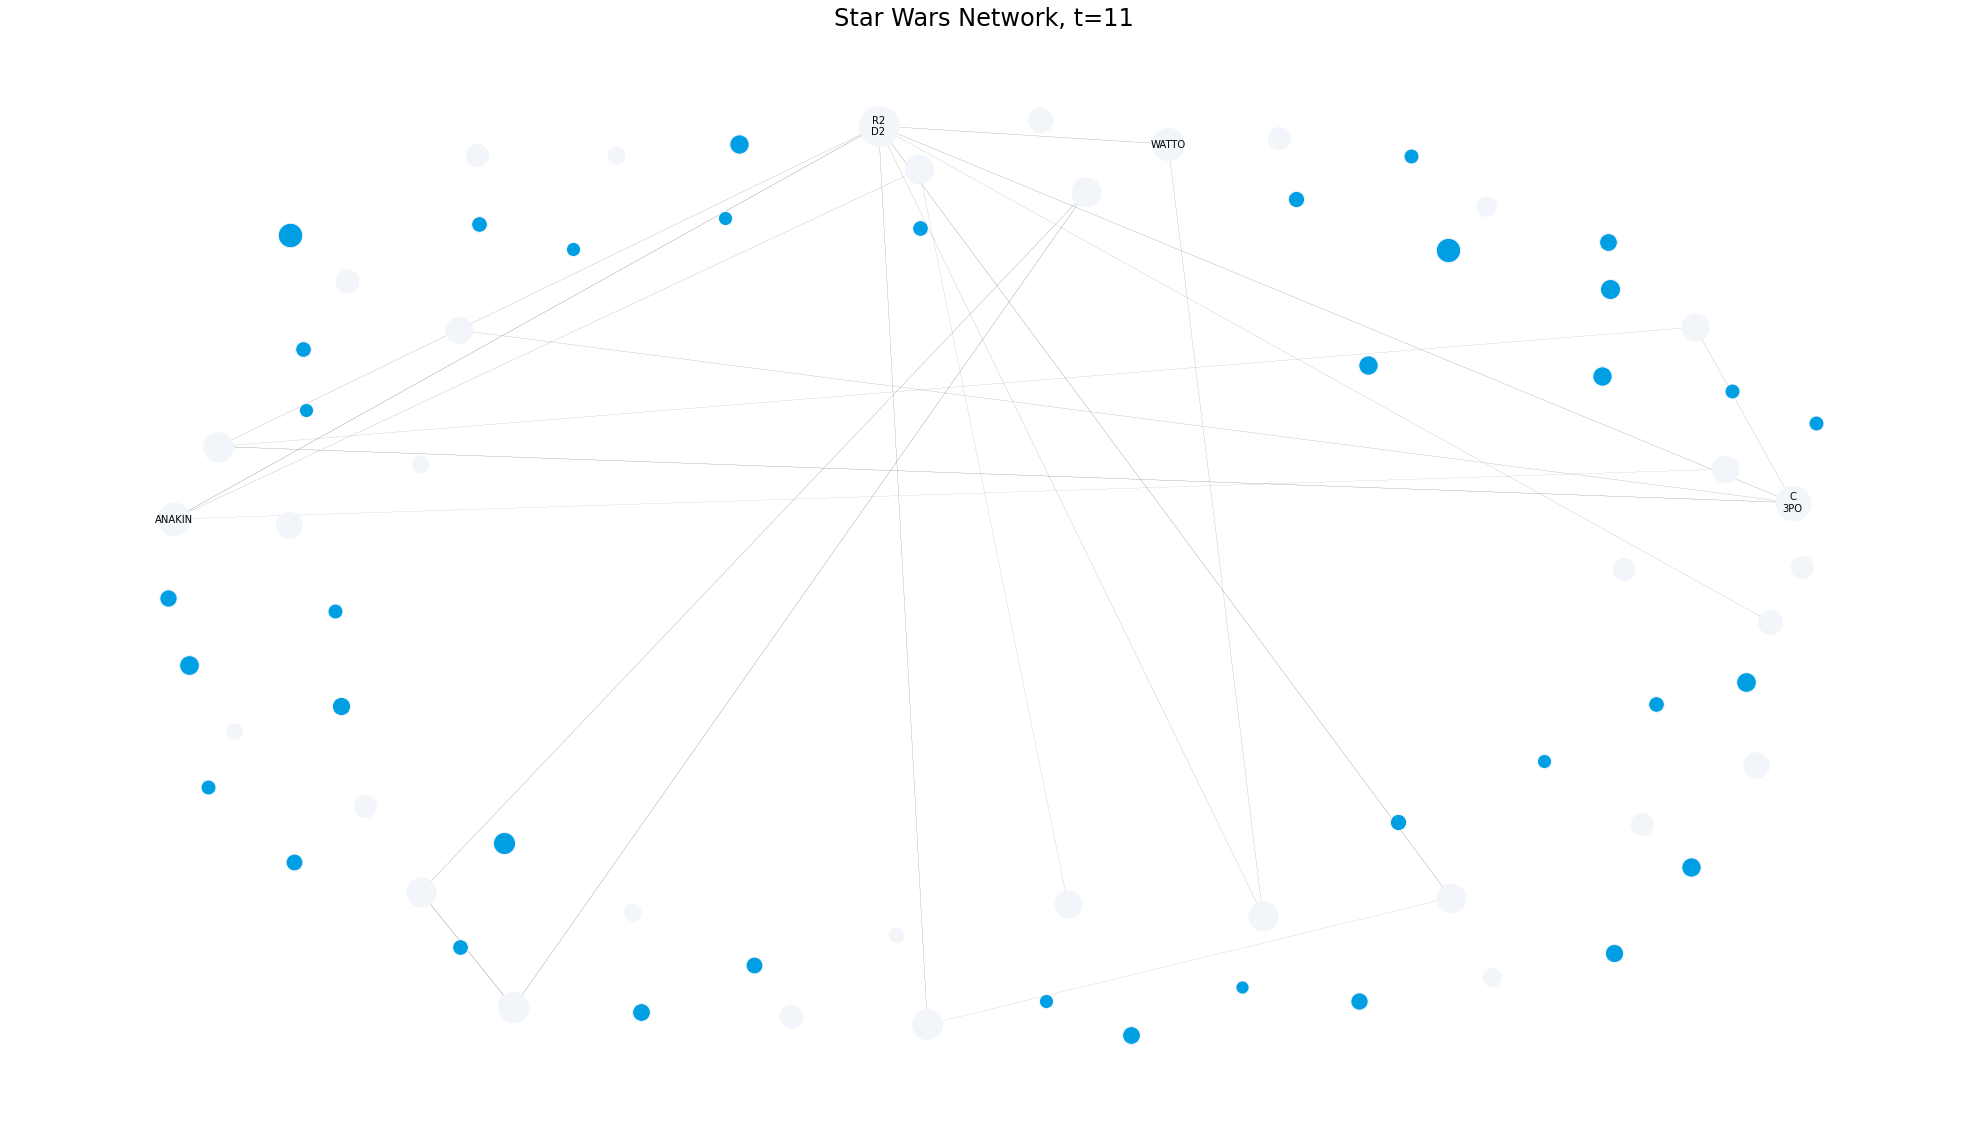

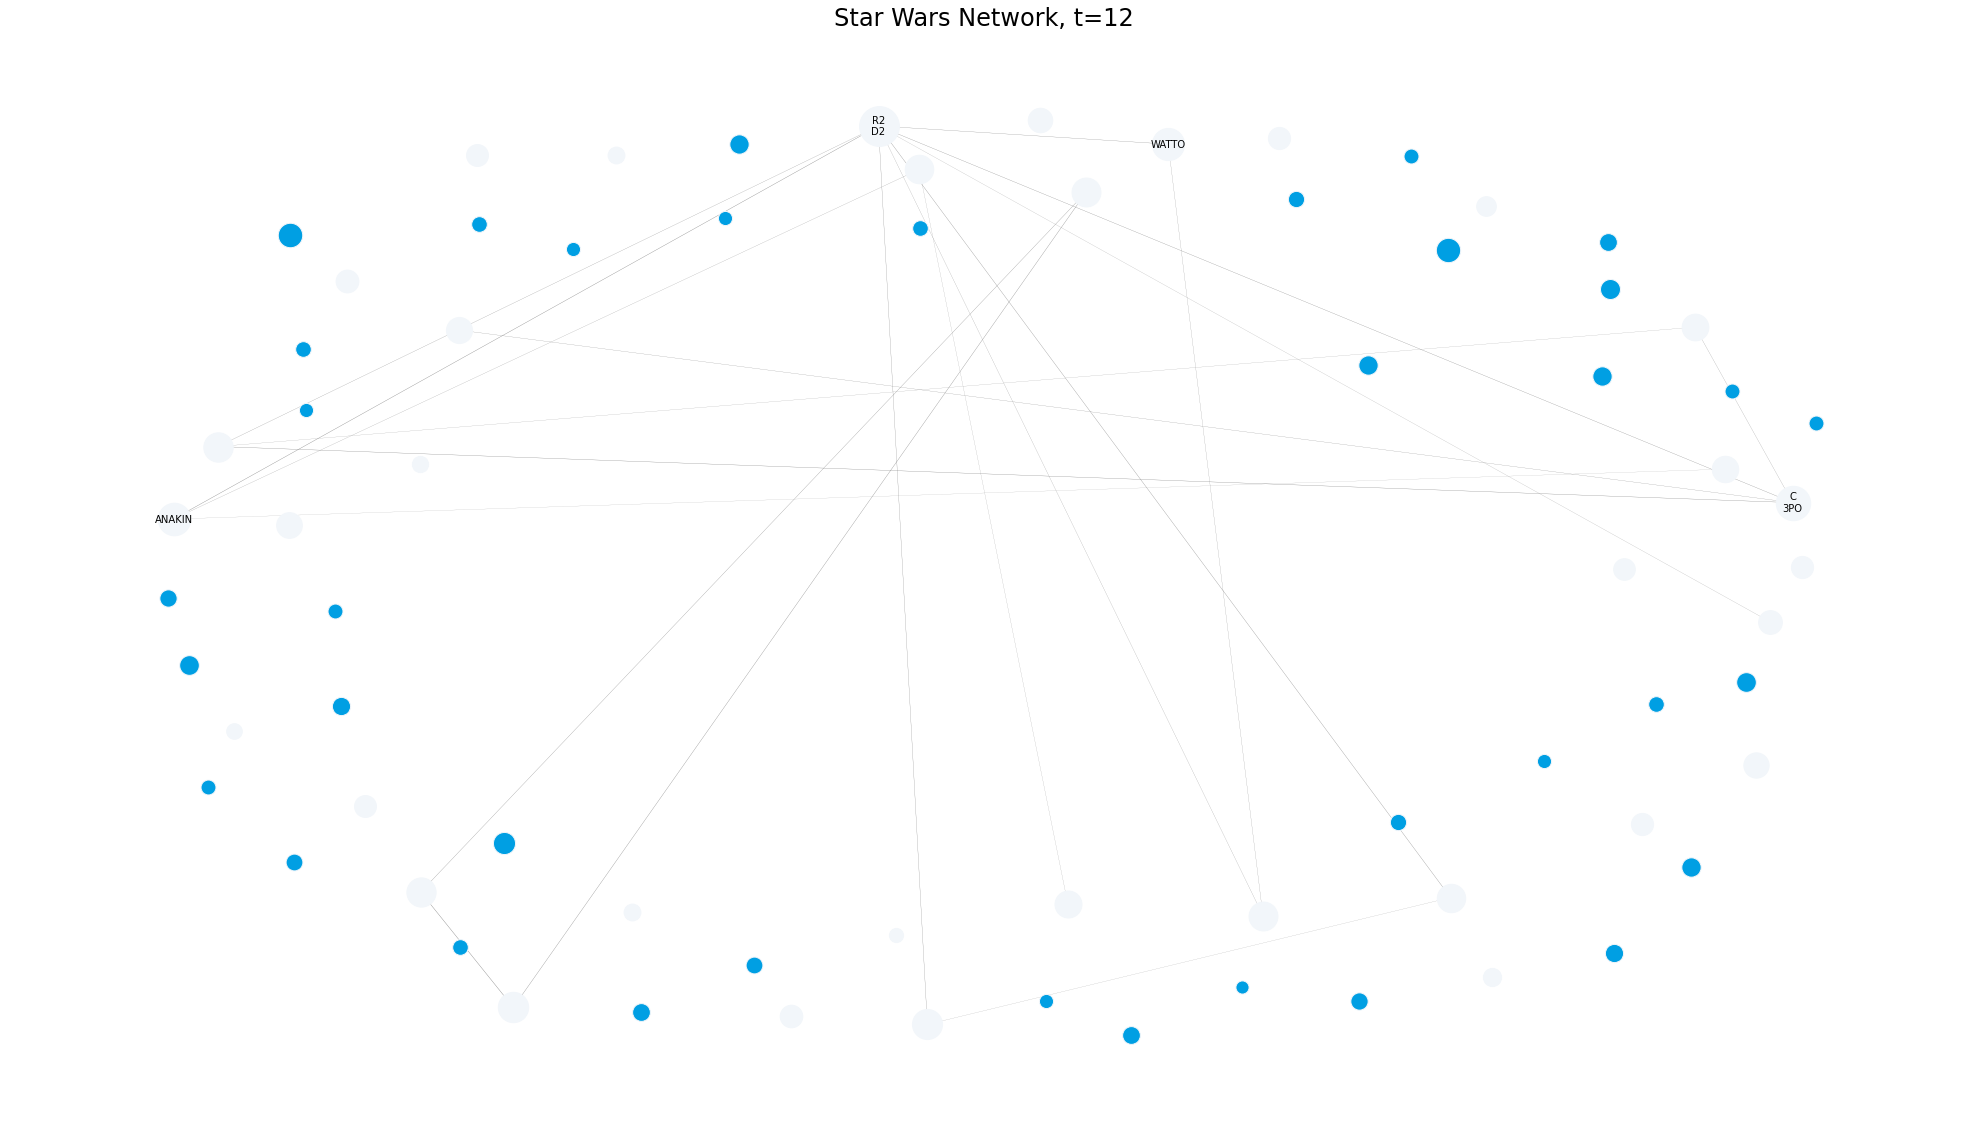

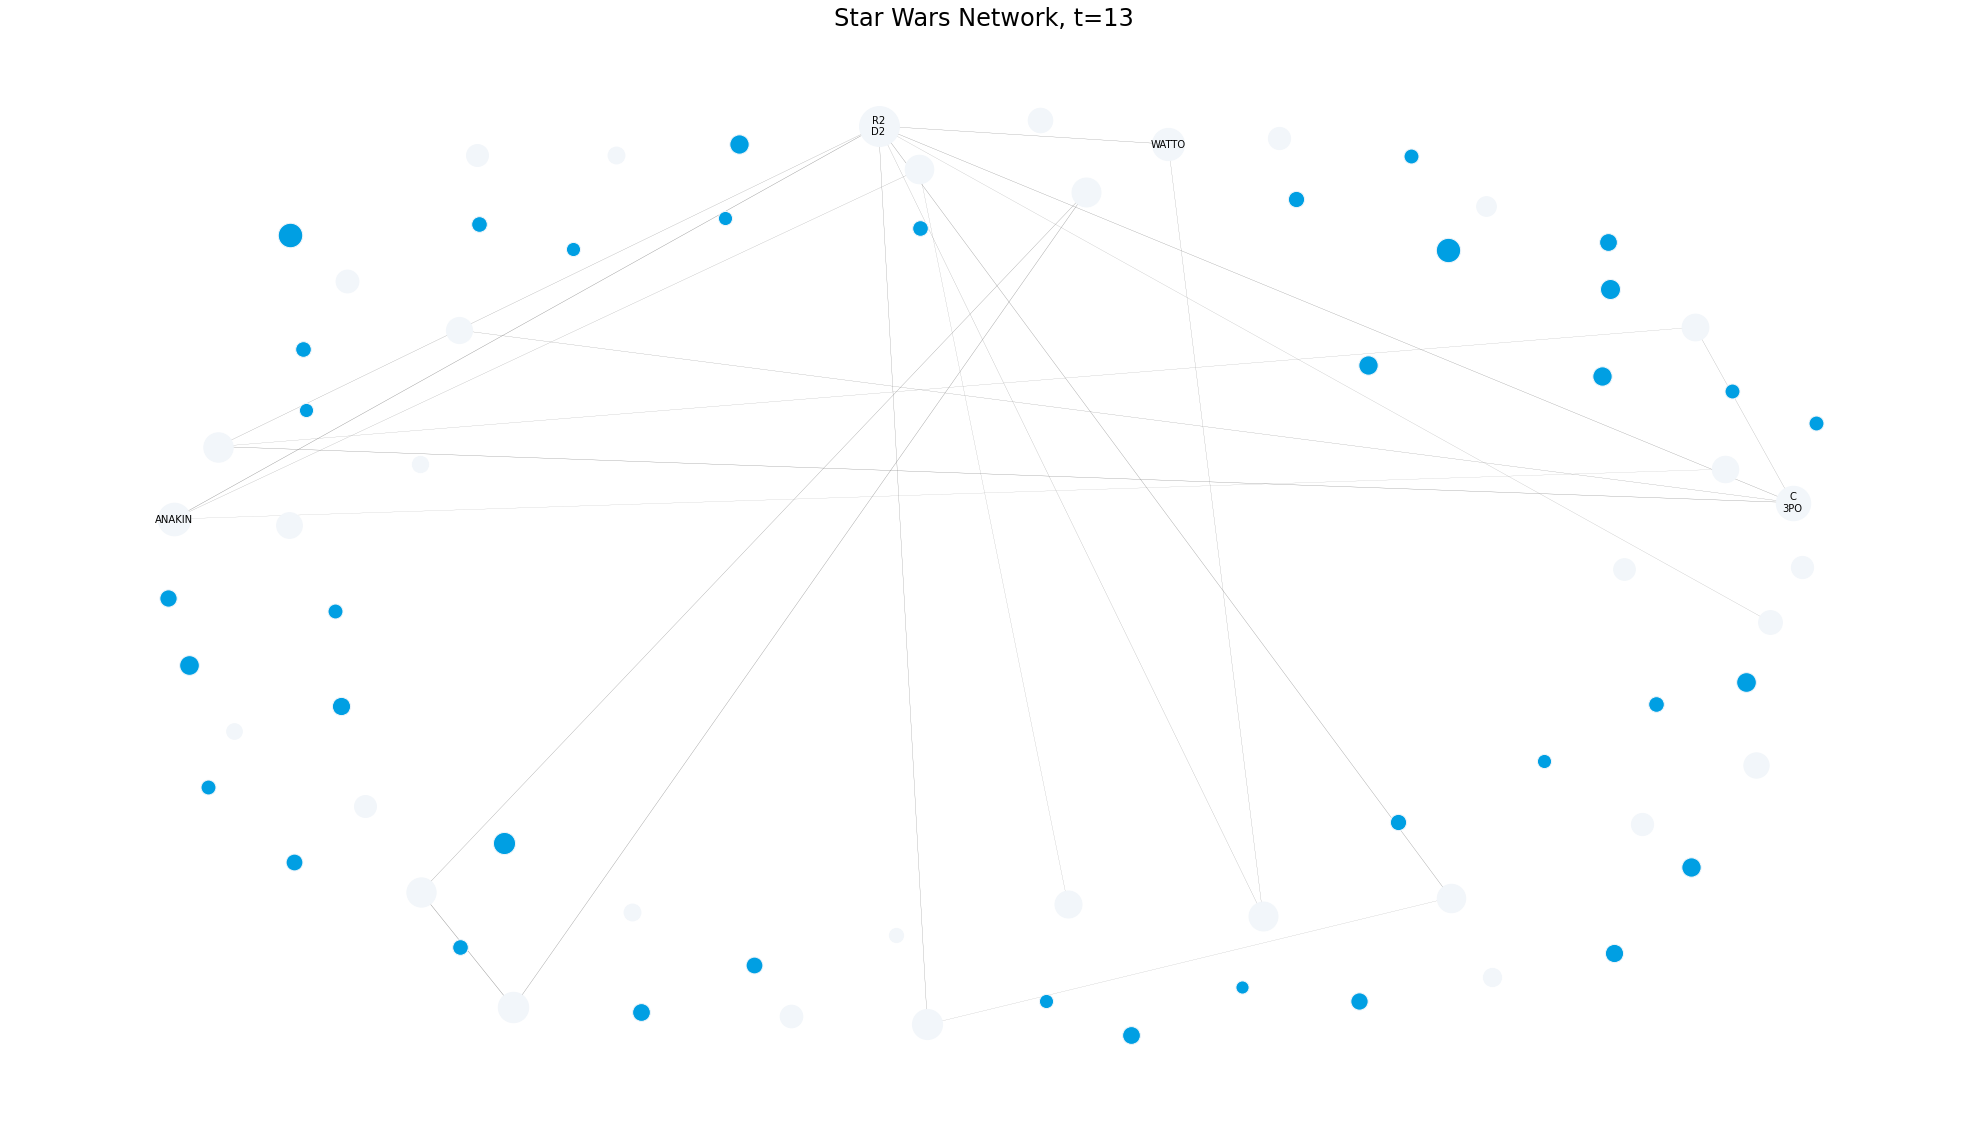

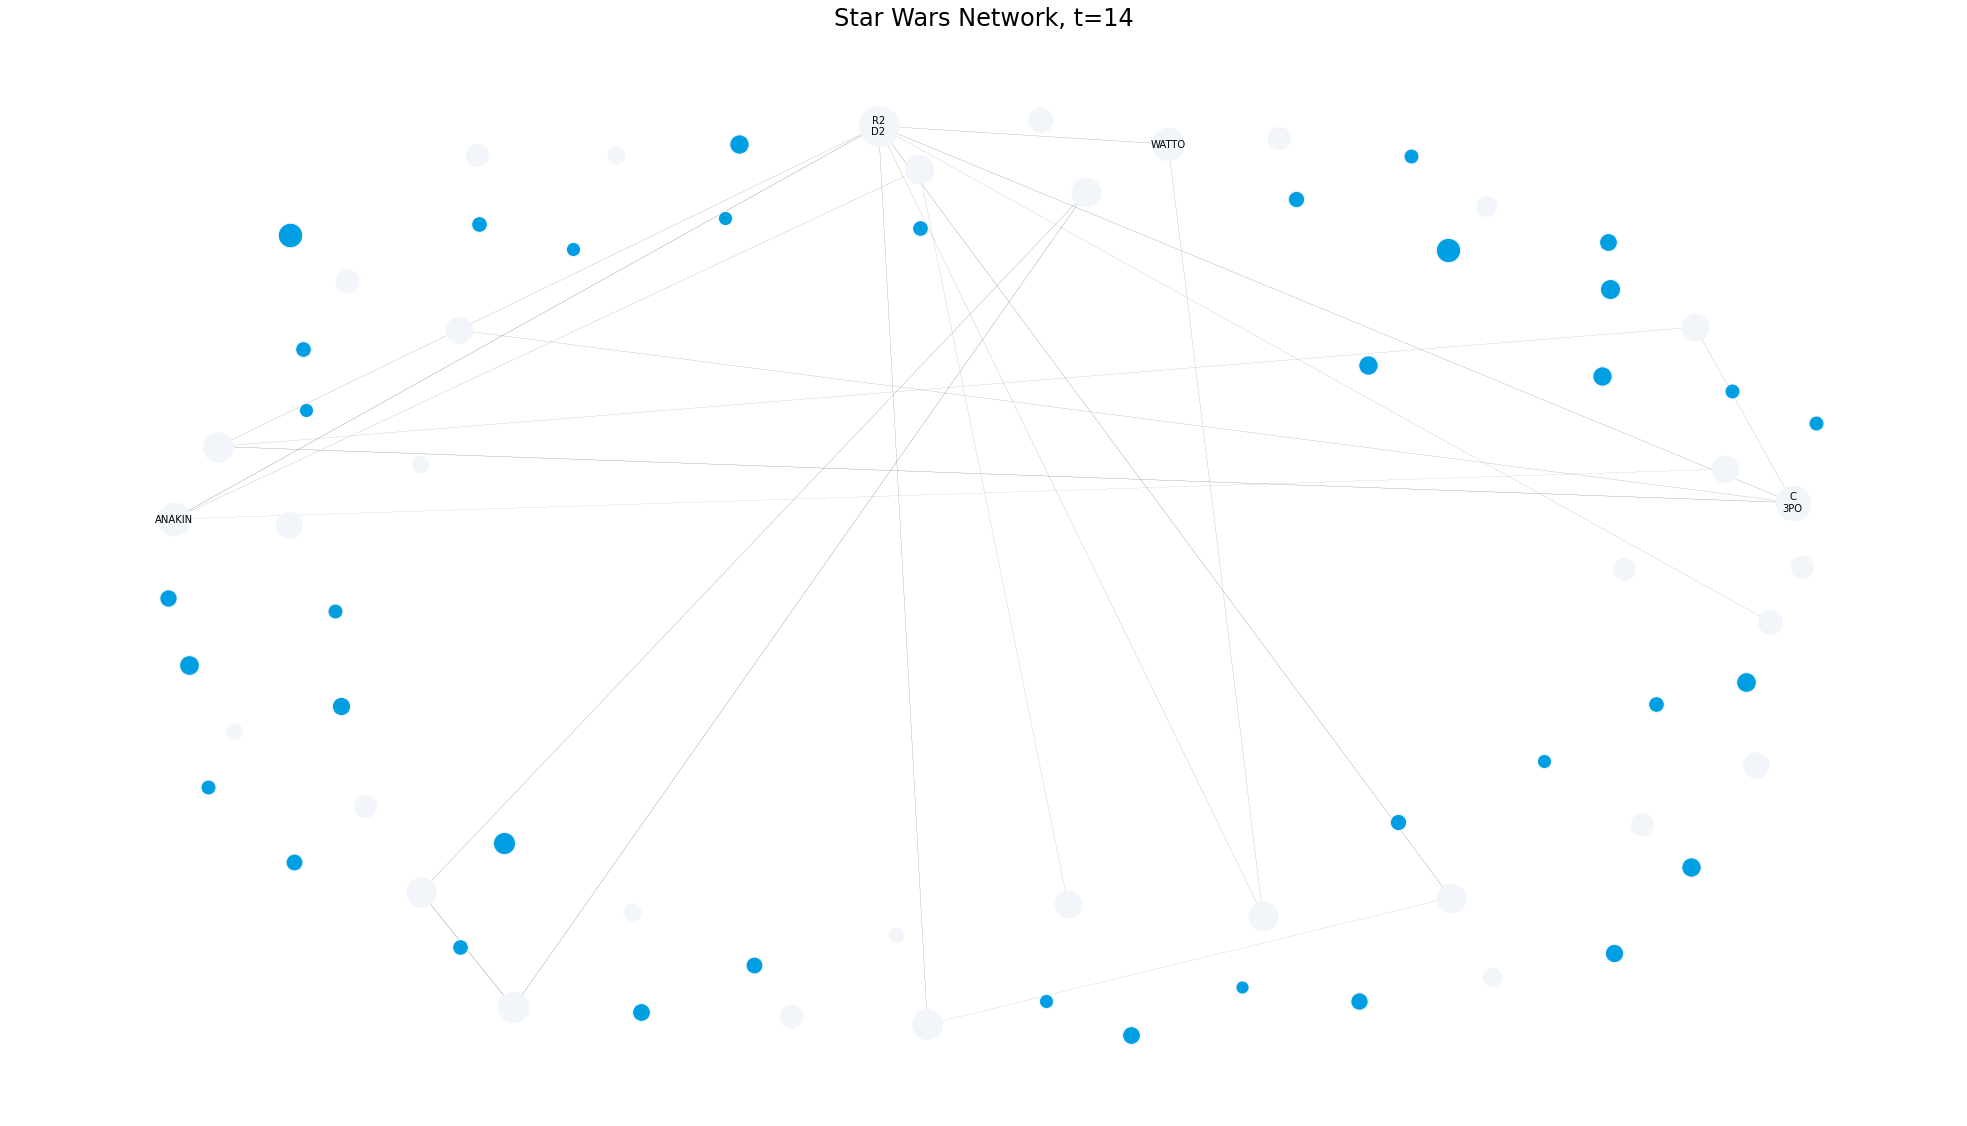

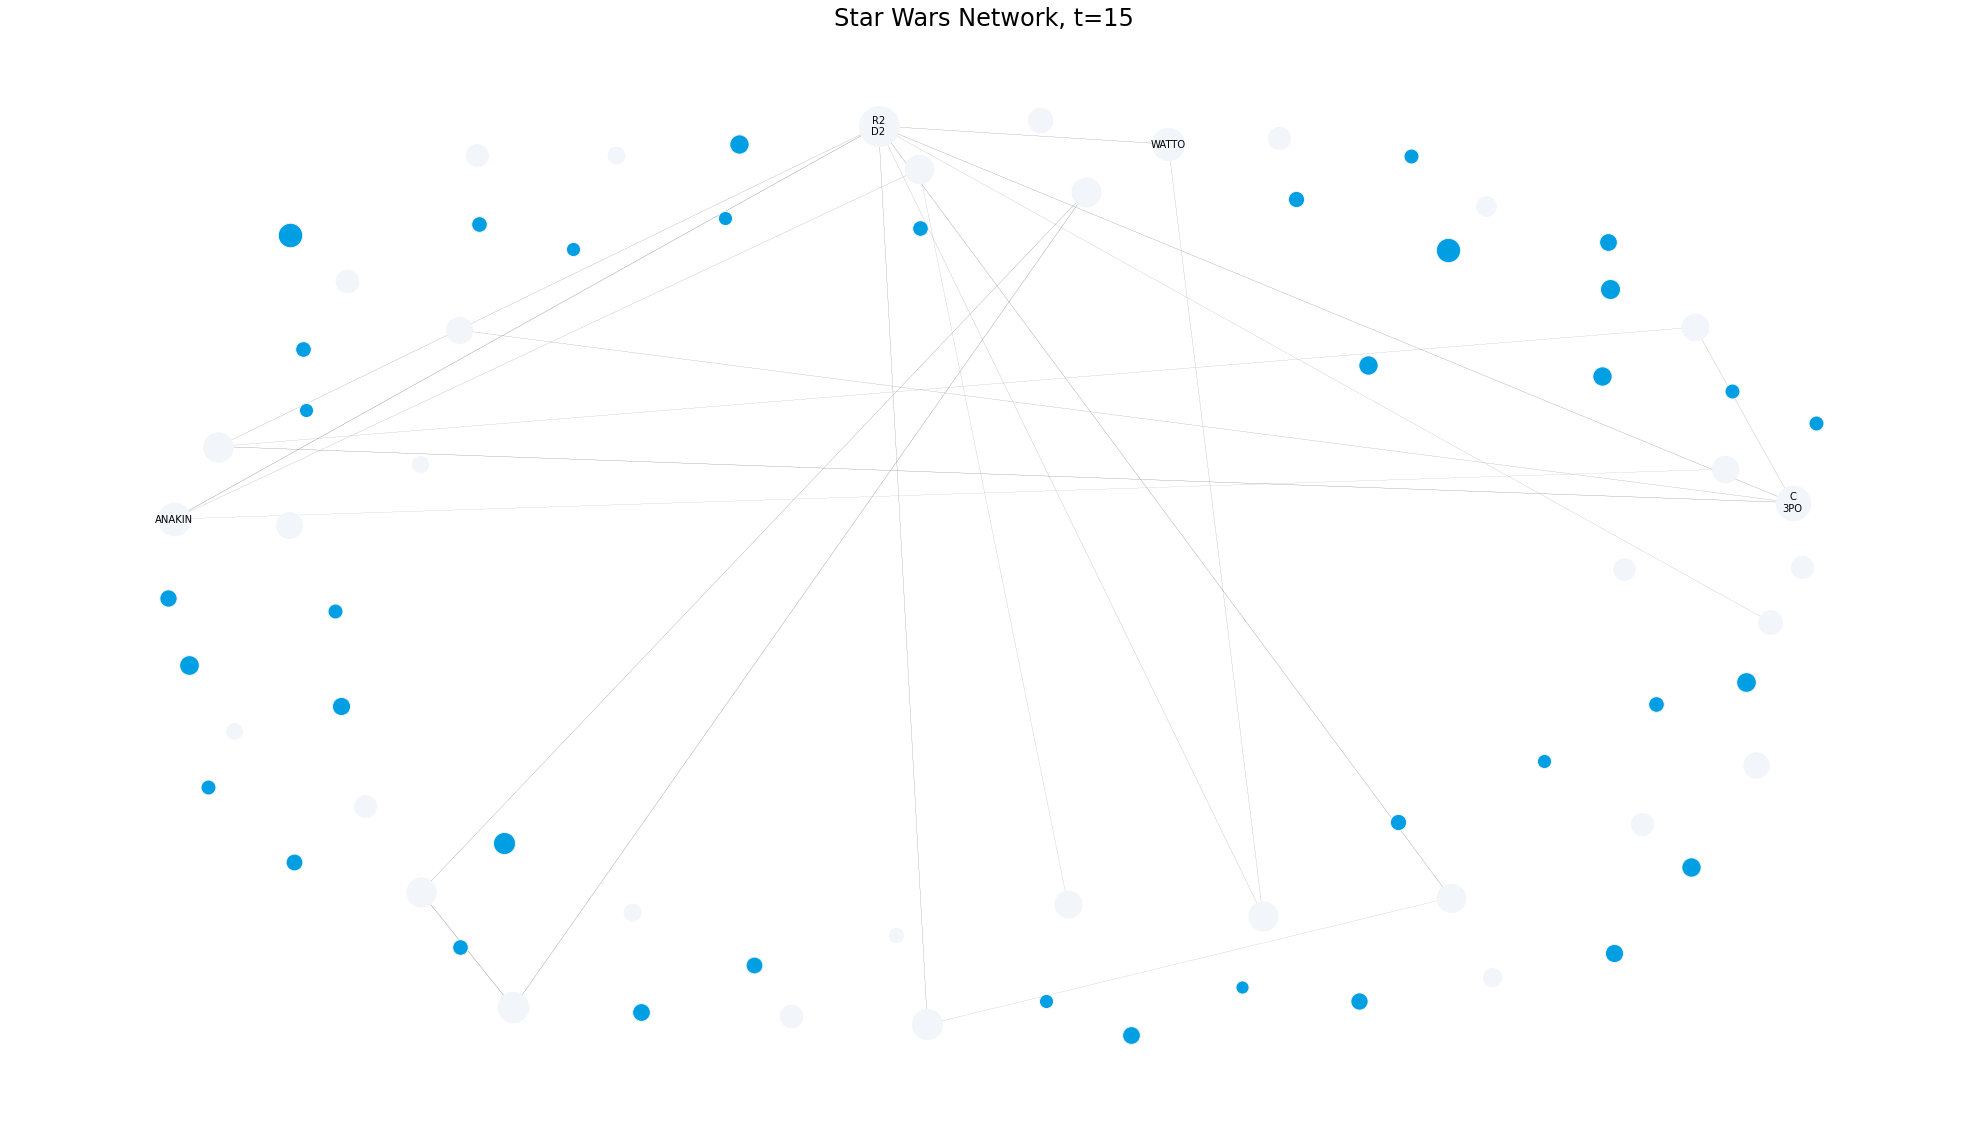

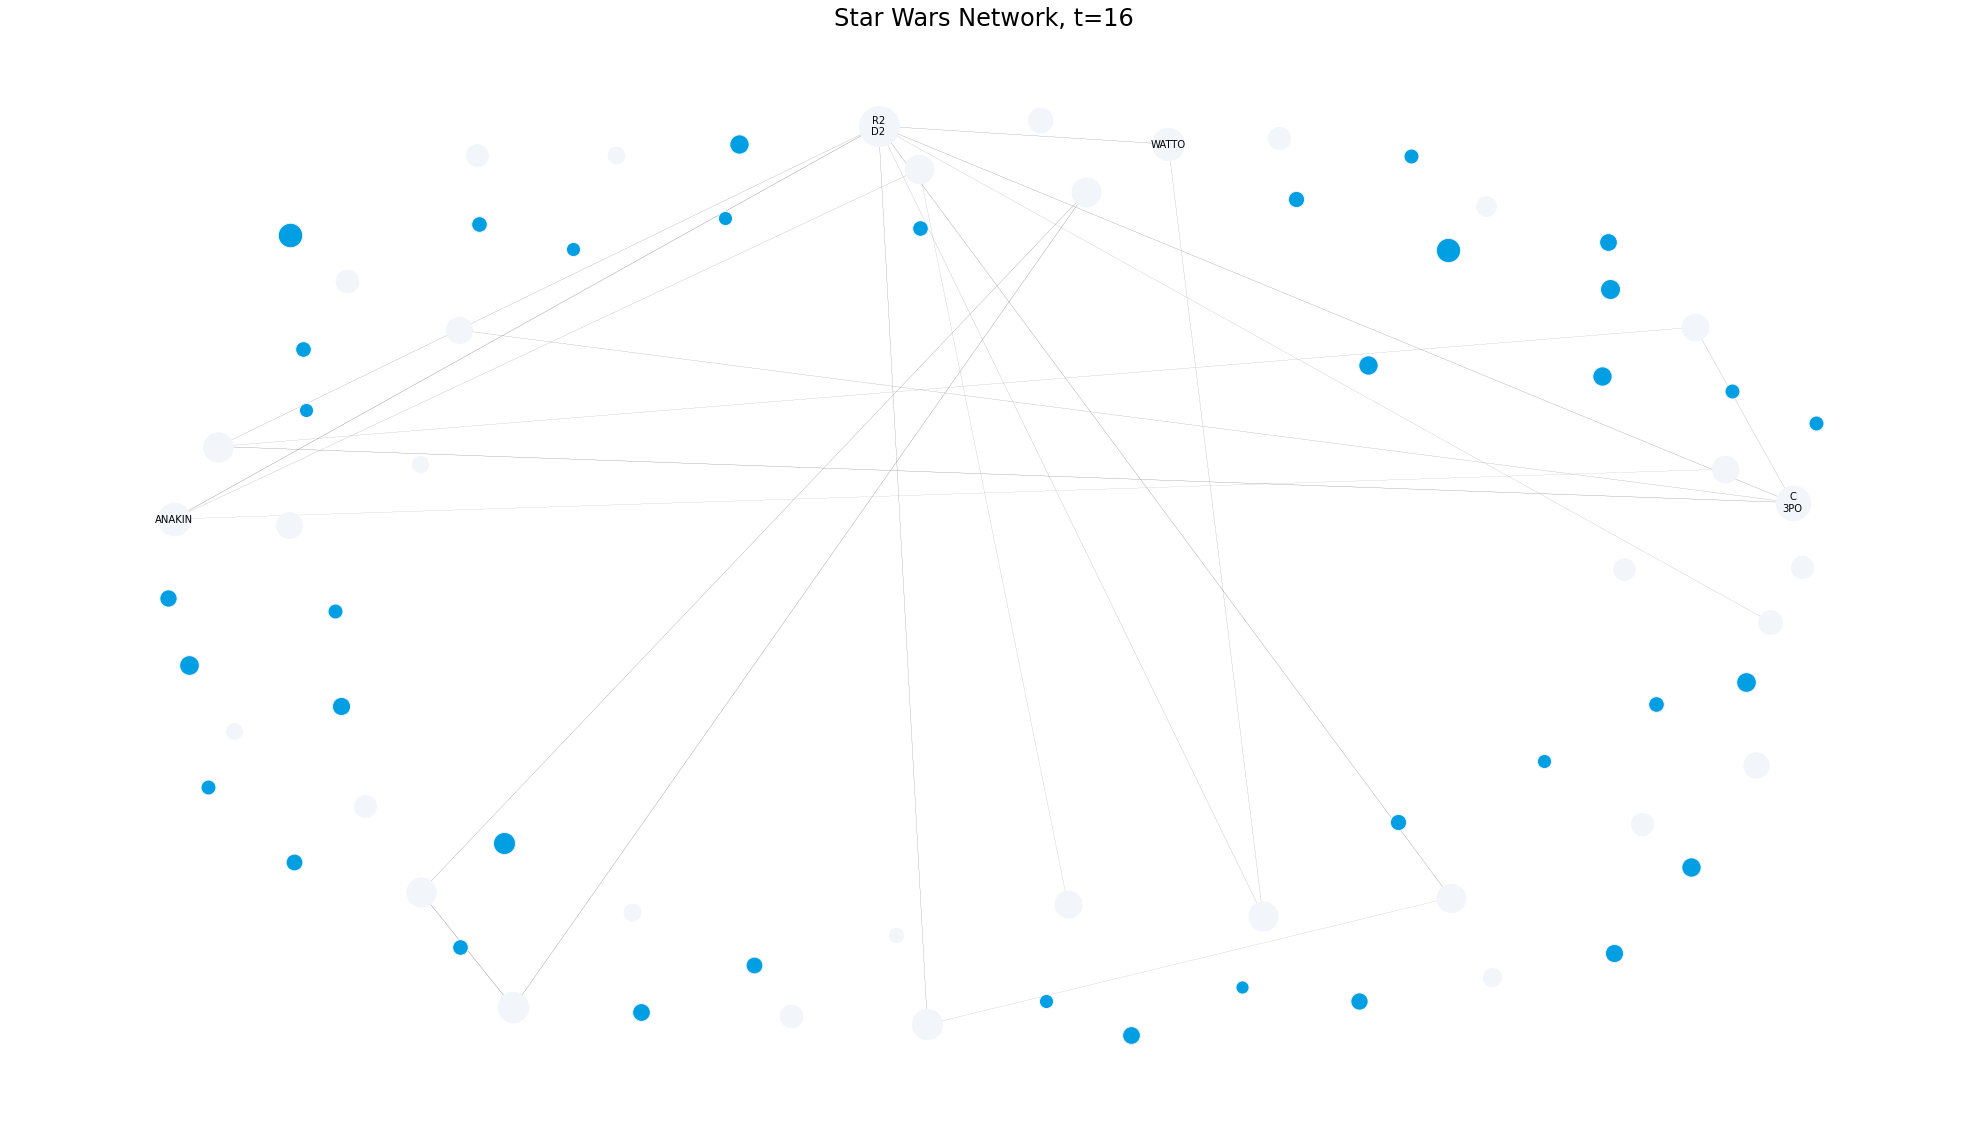

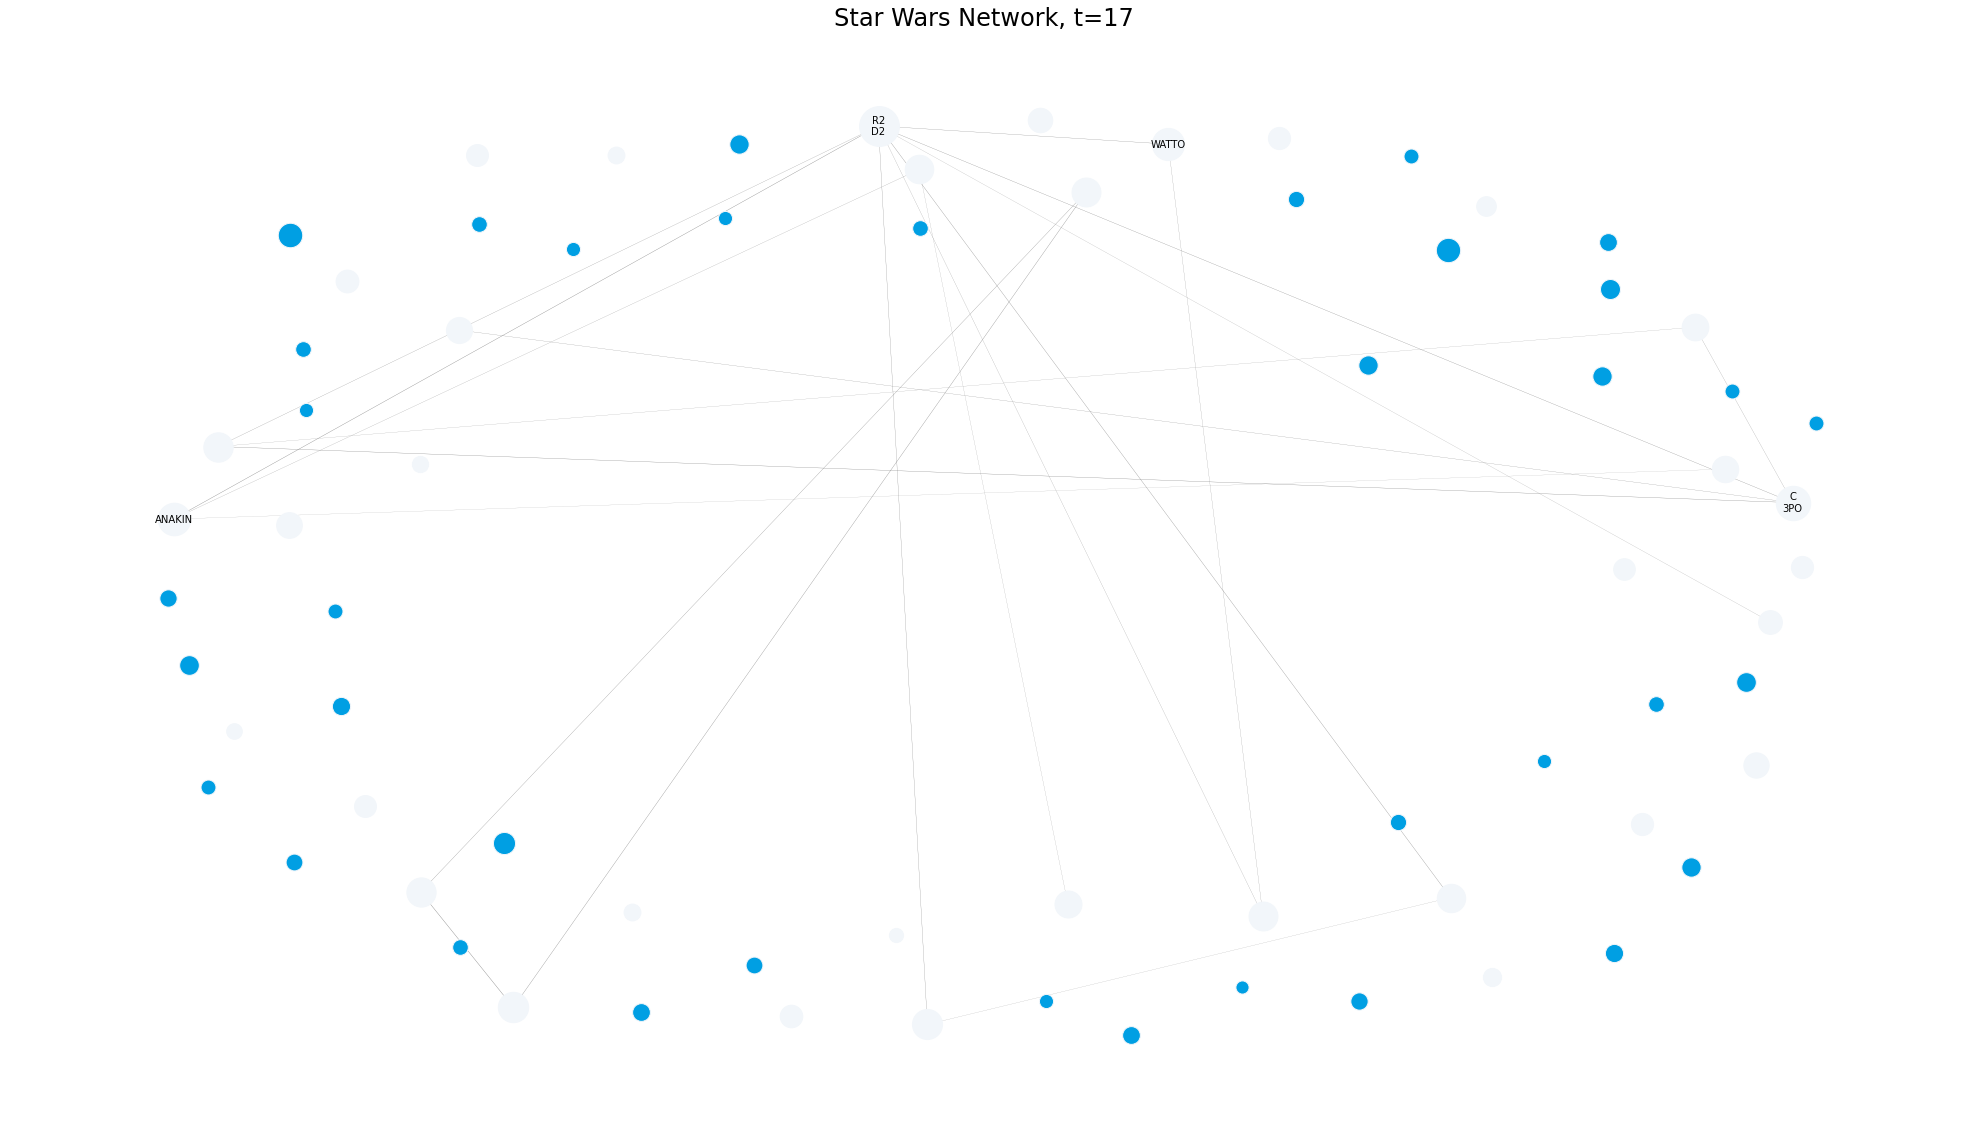

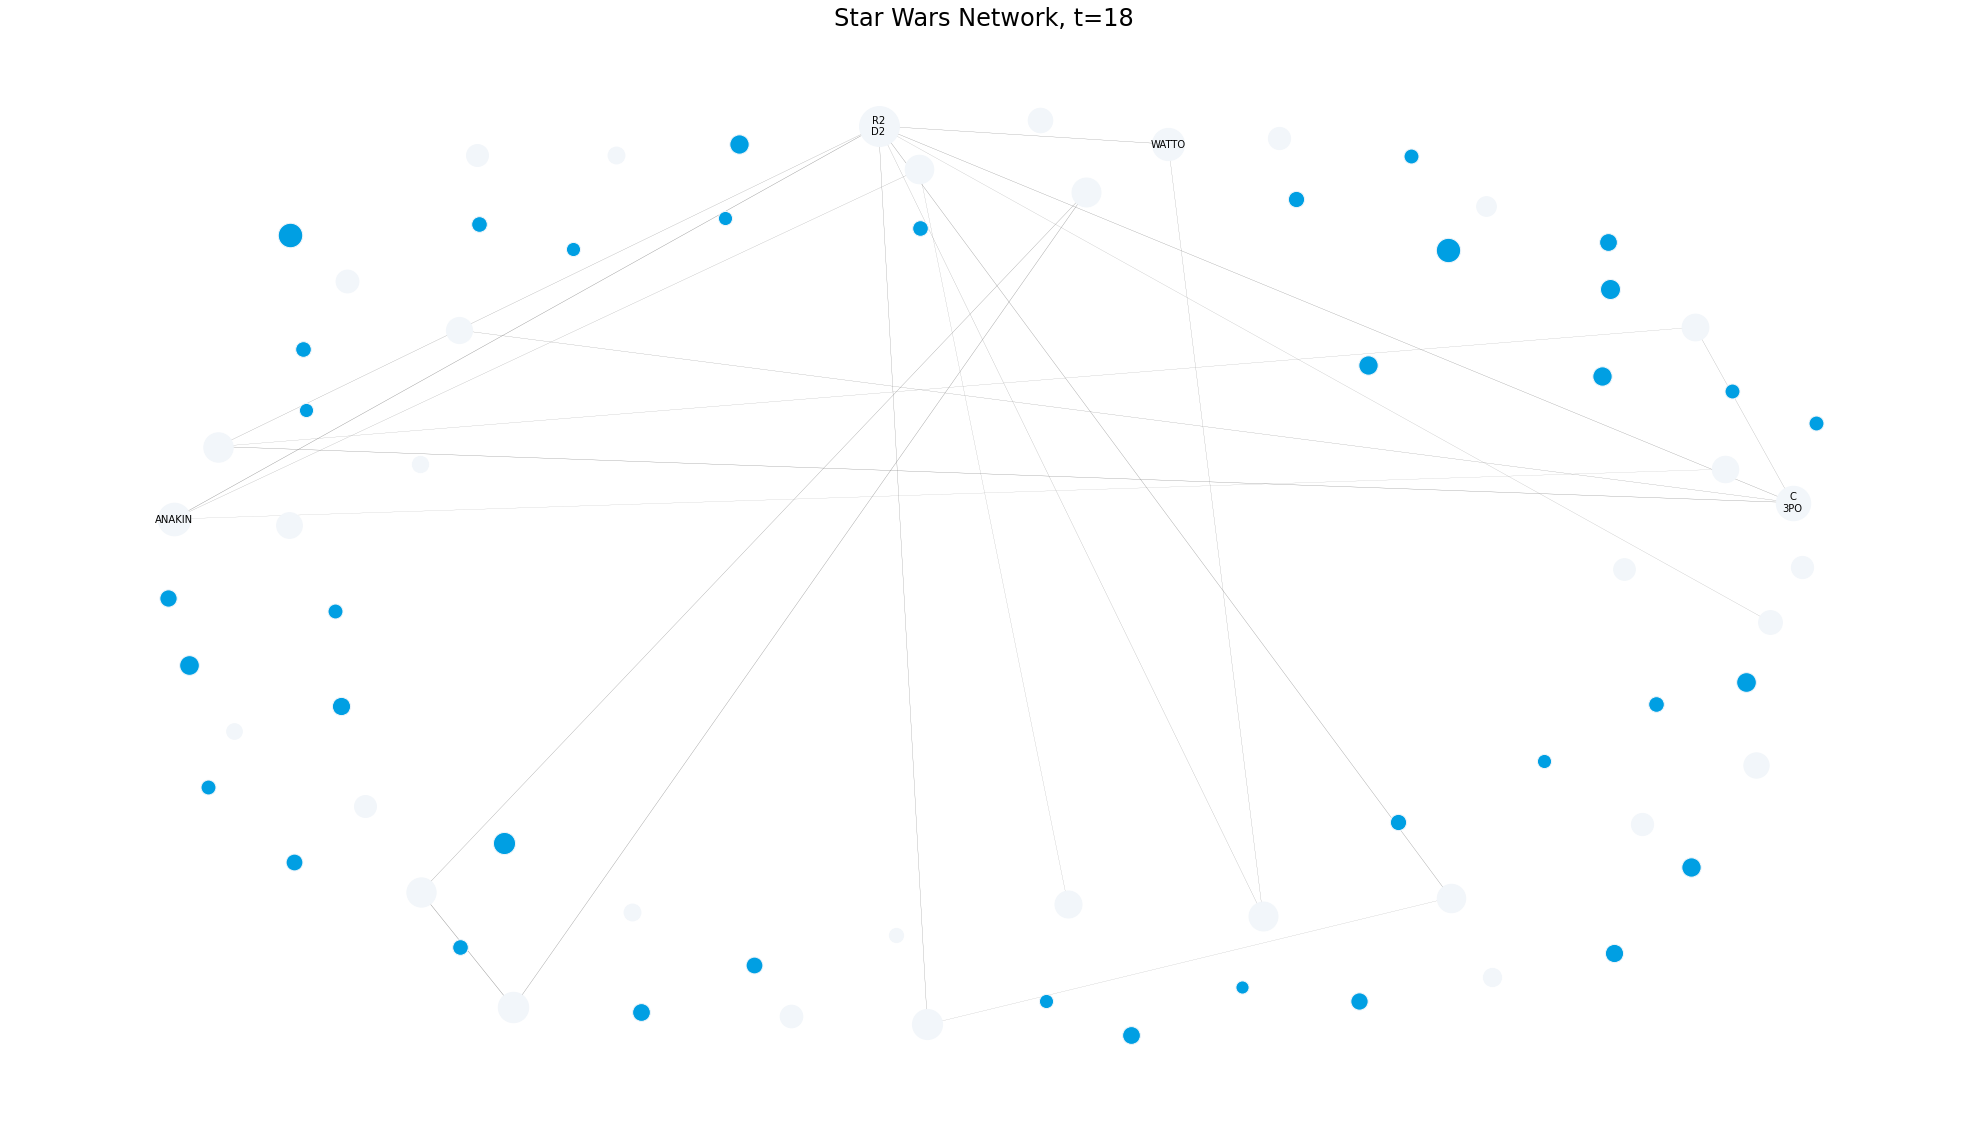

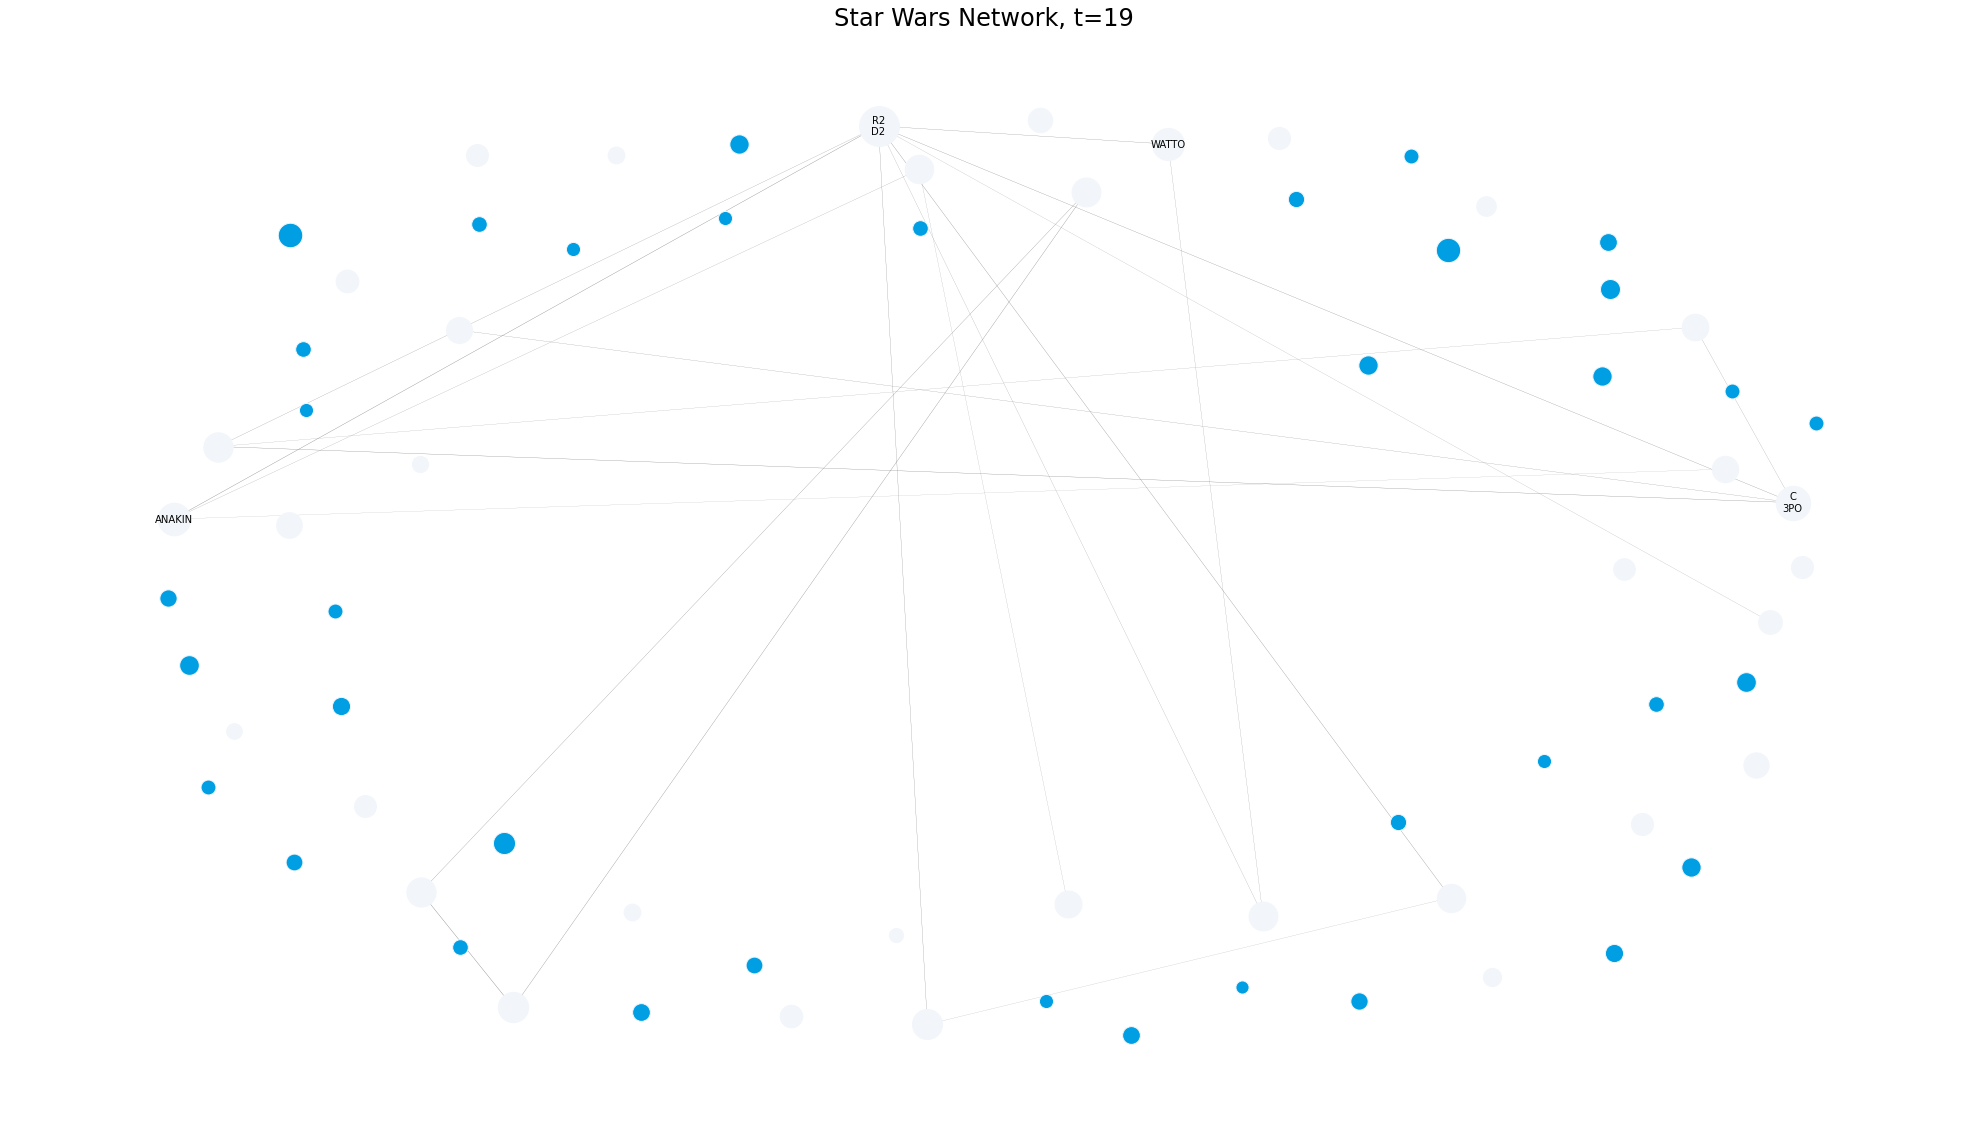

In [ ]:
for t in range(20):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)
    print(infection_times)
print(len(infection_times))

In [ ]:
len(infection_times)

21

In [ ]:
#Houda
model=[]
nodos_infectados=[]
nodos_infectados_list=[]
trial=100
time=  20
for x in range(round(time/2)):
   for y in range(round(time/2)):
     for z in range(round(time/2)):
        #infection_times = {'LUKE':x,'CHEWBACCA':y, 'R2-D2':z}
        for tr in range(trial):
          infection_times = {'LUKE':x,'CHEWBACCA':y, 'R2-D2':z}
          model.append({'LUKE':x,'CHEWBACCA':y, 'R2-D2':z})
          for s in range(time):
              infection_times = independent_cascade(subG,s,infection_times)
              #print(infection_times)
        nodos_infectados.append(len(infection_times))
        nodos_infectados_list.append(infection_times)
       #print({'LUKE':x,'CHEWBACCA':y,'R2-D2':z}, "infected=", nodos_infectados[-1])
        #print("MEANS of" trial"=",{'LUKE':x,'CHEWBACCA':y,'R2-D2':z}, "mean_infected=", np.mean(nodos_infectados[-trial:]),"Difference=",(np.mean(nodos_infectados[-trial:])-np.mean(nodos_infectados[0:trial]))/np.mean(nodos_infectados[-trial:]))
        #print(nodos_infectados[-trial:])
#dict_trial=dict(zip(model,nodos_infectados))

In [ ]:
model

In [ ]:
nodos_infectados

[24, 31, 17, 24, 26, 24]

In [ ]:
#Houda
np.array(nodos_infectados).max(), np.array(nodos_infectados).min(), np.array(nodos_infectados).mean()
x=np.array(nodos_infectados)>np.array(nodos_infectados)[0]
len(np.array(nodos_infectados)[x])/len(np.array(nodos_infectados))

0.3333333333333333

In [ ]:
x

array([False,  True, False, False,  True, False])

In [ ]:
#Houda
model_df=pd.DataFrame(model)
model_df.to_csv("model_df.csv")

In [ ]:
#Houda
nodos_infectados_df=pd.DataFrame(nodos_infectados)
nodos_infectados_df.to_csv("nodos_infectados_df.csv")

In [ ]:
#Houda
infected_nodes=pd.concat([model_df,nodos_infectados_df], axis=1)

In [ ]:
infected_nodes

LUKE  CHEWBACCA  R2-D2   0
0         0          0      0  25
1         0          0      1  17
2         0          0      2  28
3         0          0      3  14
4         0          0      4  24
...     ...        ...    ...  ..
99995     9          9      5  27
99996     9          9      6  30
99997     9          9      7  31
99998     9          9      8  26
99999     9          9      9  23

[100000 rows x 4 columns]

In [ ]:
model

["'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHEWBACCA=' y, 'R2-D2=' z",
 "'LUKE=' x,'CHE

In [ ]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [ ]:
top.head()

Degree  Weighted Degree  PageRank  Betweenness
R2-D2        38              251  0.095454     0.186114
C-3PO        27              139  0.055358     0.076867
WATTO        26              107  0.043793     0.093224
ANAKIN       26              112  0.046605     0.056407
OBI-WAN      23               64  0.029293     0.117277

In [ ]:
methods = top.columns

print(nx.info(subG))
print(nx.info(SW))

Graph with 72 nodes and 323 edges
Graph with 84 nodes and 342 edges


In [ ]:
len(subG.nodes)

72

In [ ]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)
              

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')

In [ ]:
res_df.index = res_df.index/len(subG.nodes())

In [ ]:
res_df.head()

Degree  Weighted Degree  PageRank  Betweenness
budget                                                  
0.000000    0.00             0.00      0.00         0.00
0.013889    0.32             0.31      0.31         0.11
0.027778    0.31             0.31      0.32         0.32
0.041667    0.32             0.31      0.31         0.33
0.055556    0.32             0.32      0.33         0.34

Text(0.5, 0, 'Seeding Budget (out of graph size)')

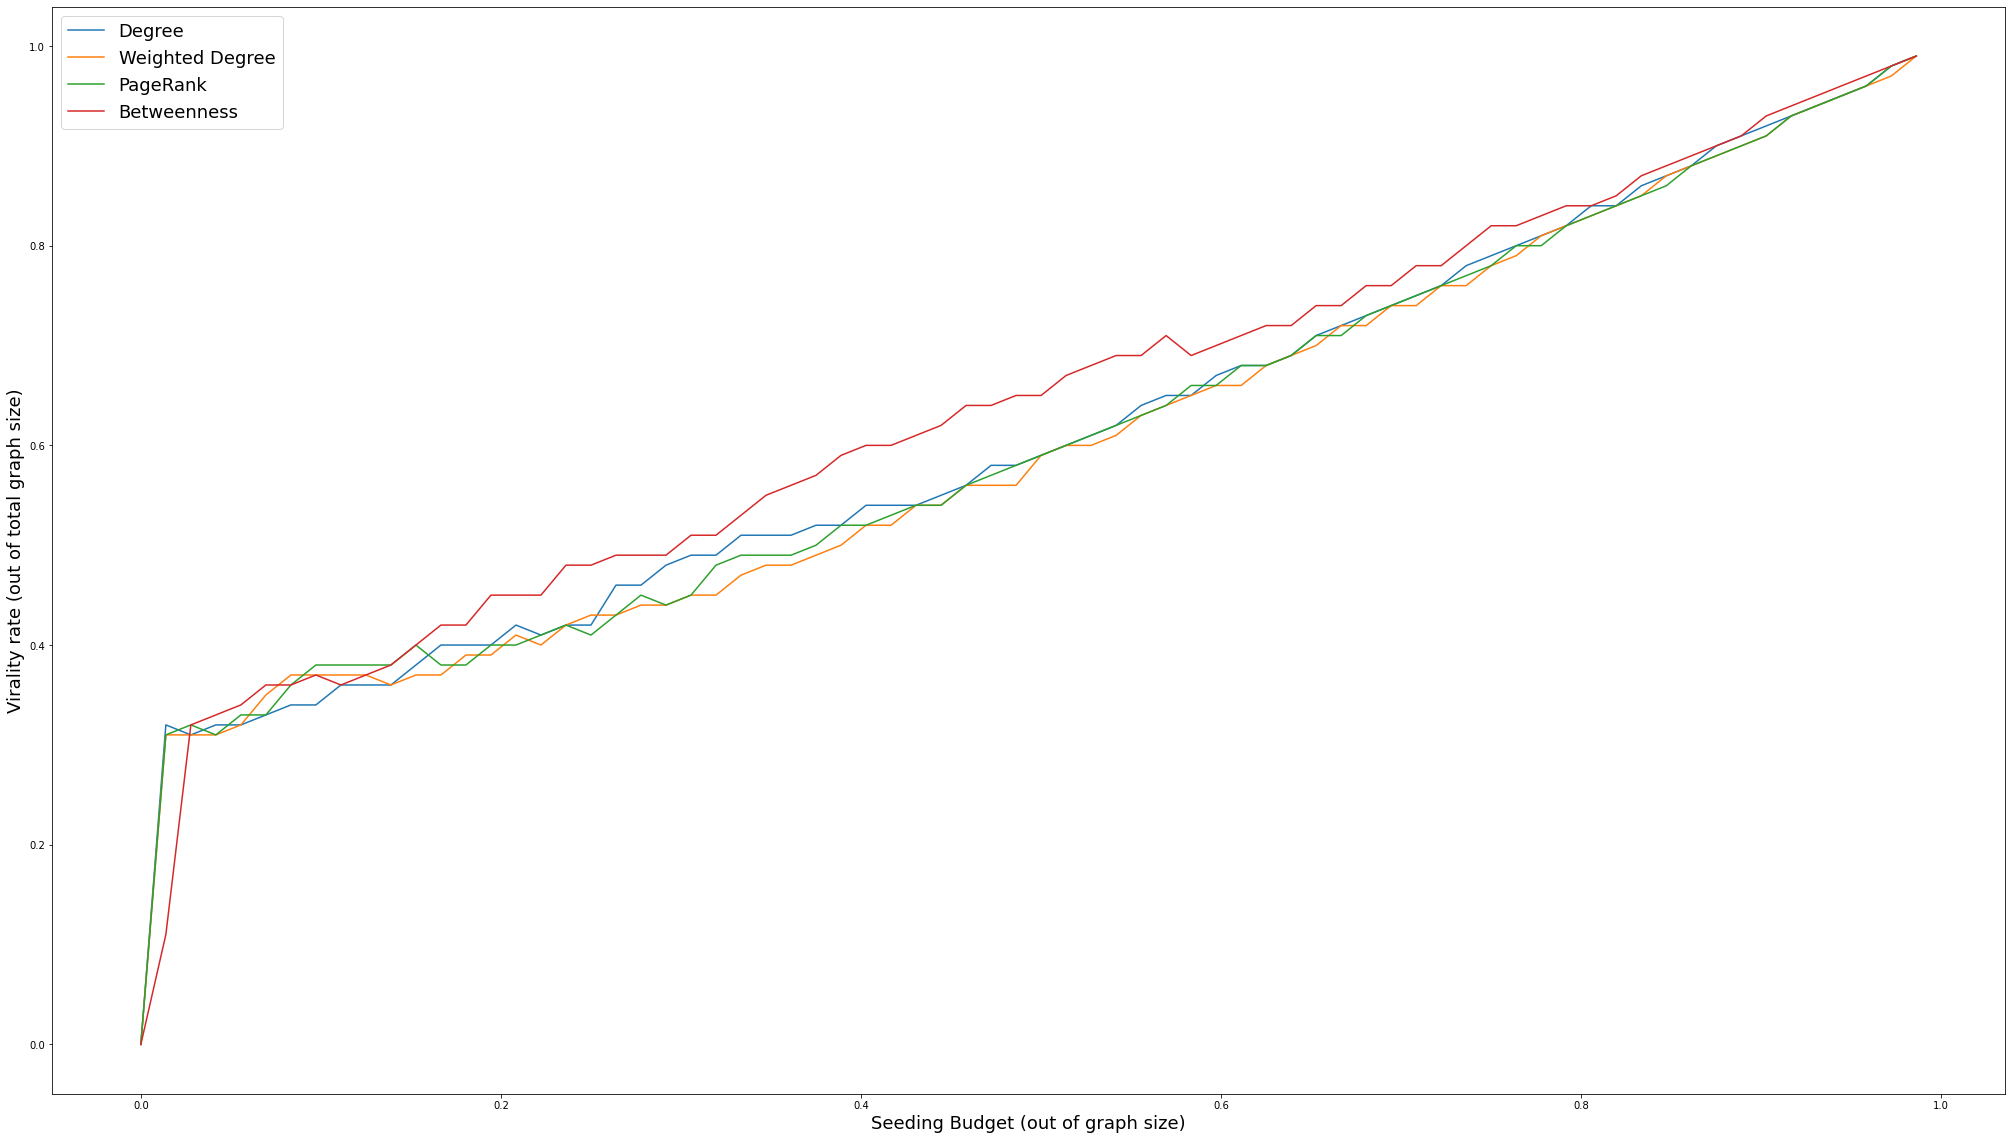

In [ ]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

In [ ]:
from itertools import product

budget=3

seed_sets = list(product(*[subG.nodes()]*budget))

print(len(seed_sets),'Seeding options')

373248 Seeding options


In [ ]:
seed_sets

In [ ]:
budget = 3
trials = 20
all_results = []
results = {'budget':budget}
for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t= 0
        infection_times = {n:0 for n in seed}
        while len(infection_times)>infected:
            #t+=1
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t+=1
        infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)

all_results.append(results)

  0%|          | 0/373248 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
infection_times

set()

In [ ]:
sorted(results.items(), key = lambda x: x[1], reverse=True)[:72]

[('budget', 2),
 (('BIGGS', 'BAIL ORGANA'), 0.38),
 (('ANAKIN', 'GOLD LEADER'), 0.37),
 (('ANAKIN', 'LEIA'), 0.37),
 (('BOBA FETT', 'C-3PO'), 0.37),
 (('RIEEKAN', 'OBI-WAN'), 0.37),
 (('BOSS NASS', 'QUI-GON'), 0.37),
 (('C-3PO', 'JAR JAR'), 0.36),
 (('C-3PO', 'MOTTI'), 0.36),
 (('SIO BIBBLE', 'PIETT'), 0.36),
 (('BIGGS', 'OBI-WAN'), 0.36),
 (('BOBA FETT', 'ANAKIN'), 0.36),
 (('R2-D2', 'SEBULBA'), 0.36),
 (('LUKE', 'C-3PO'), 0.36),
 (('LUKE', 'SIO BIBBLE'), 0.36),
 (('LUKE', 'R2-D2'), 0.36),
 (('OZZEL', 'WATTO'), 0.36),
 (('WATTO', 'RIEEKAN'), 0.36),
 (('WATTO', 'OZZEL'), 0.36),
 (('ANAKIN', 'OBI-WAN'), 0.35),
 (('ANAKIN', 'RIEEKAN'), 0.35),
 (('ANAKIN', 'TARKIN'), 0.35),
 (('ANAKIN', 'KITSTER'), 0.35),
 (('ANAKIN', 'FODE/BEED'), 0.35),
 (('ANAKIN', 'LUKE'), 0.35),
 (('C-3PO', 'BOBA FETT'), 0.35),
 (('C-3PO', 'SEBULBA'), 0.35),
 (('PADME', 'SIO BIBBLE'), 0.35),
 (('SIO BIBBLE', 'JAR JAR'), 0.35),
 (('SIO BIBBLE', 'CHEWBACCA'), 0.35),
 (('SIO BIBBLE', 'OZZEL'), 0.35),
 (('ORN FREE TAA', 